In [244]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from pygam import LinearGAM, s
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from statsmodels.discrete.discrete_model import Probit
from scipy.stats import norm
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera


In [247]:
ties_df = pd.read_excel("TIESv4-1.xls")
cow_df = pd.read_csv("COW-country-codes.csv")
plty_df = pd.read_excel("POLITY5-PRC.xlsx")
prob_df = pd.read_csv("all_data_probabilities.csv")

In [248]:
prob_df

,ISO3,Year,predicted_probability
0,AFG,1989,0.051824
1,AFG,1990,0.032782
2,AFG,1991,0.038120
3,AFG,1992,0.032782
4,AFG,1993,0.032782
...,...,...,...
5902,ZWE,2014,0.043076
5903,ZWE,2015,0.030556
5904,ZWE,2016,0.051824
5905,ZWE,2017,0.046487


Not enough data points for country AFG, skipping.

=== Country: AGO ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                49.0440
Distribution:                     Normal   AIC:                          -92.0879
Method:               Maximum Likelihood   BIC:                          -87.0972
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:10   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001933. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


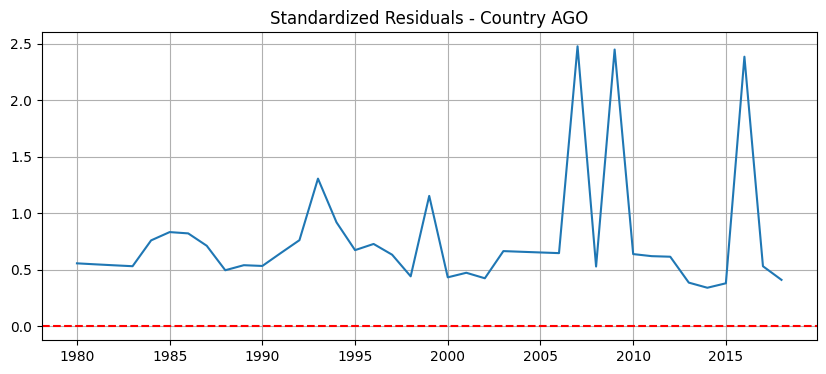


=== Country: ALB ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                75.8578
Distribution:                     Normal   AIC:                          -145.716
Method:               Maximum Likelihood   BIC:                          -140.725
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:10   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001698. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


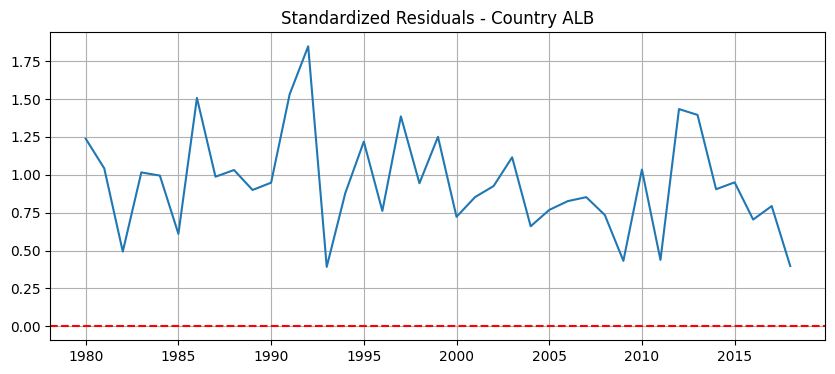


=== Country: ARE ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                77.7219
Distribution:                     Normal   AIC:                          -149.444
Method:               Maximum Likelihood   BIC:                          -144.453
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:11   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001188. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


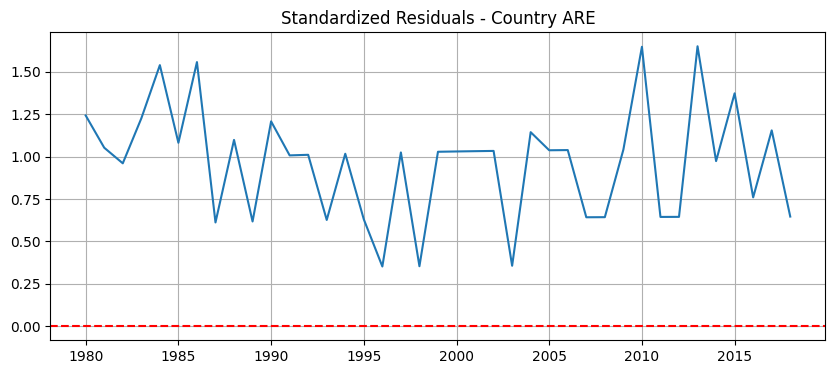

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008712. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



=== Country: ARG ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                60.7422
Distribution:                     Normal   AIC:                          -115.484
Method:               Maximum Likelihood   BIC:                          -110.494
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:11   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------

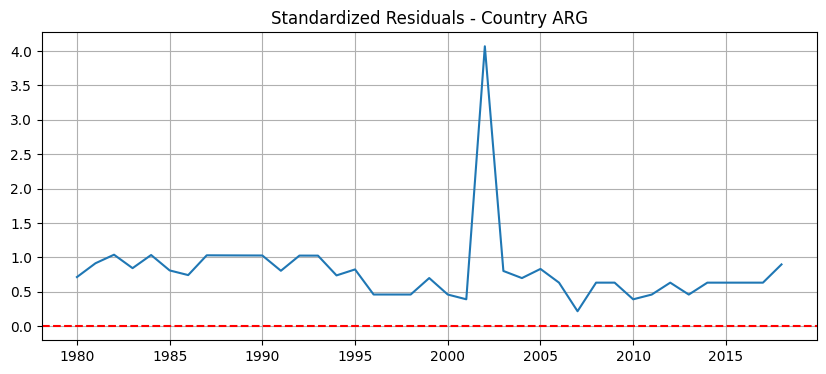

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001045. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Not enough data points for country ARM, skipping.

=== Country: AUS ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                95.3472
Distribution:                     Normal   AIC:                          -184.694
Method:               Maximum Likelihood   BIC:                          -179.704
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:11   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
---------------------

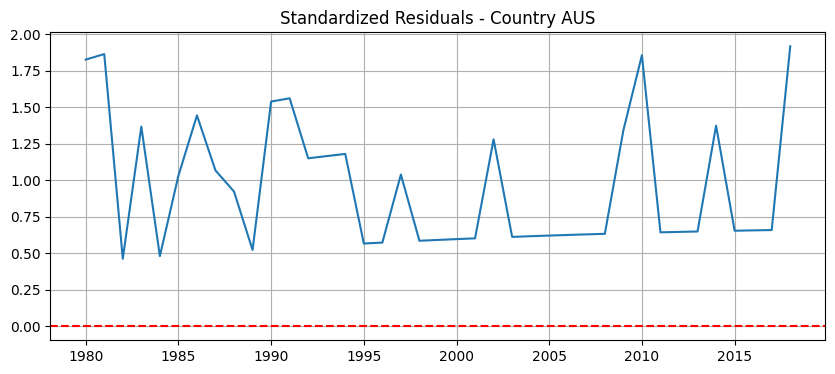


=== Country: AUT ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                96.4005
Distribution:                     Normal   AIC:                          -186.801
Method:               Maximum Likelihood   BIC:                          -181.810
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:11   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001128. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


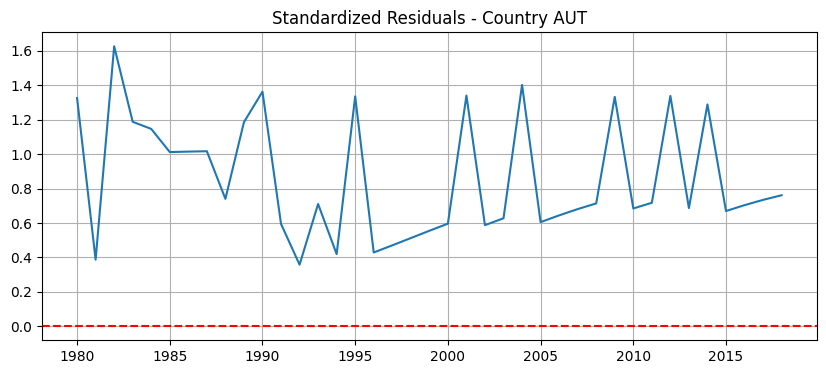

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006711. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Not enough data points for country AZE, skipping.

=== Country: BDI ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                60.3025
Distribution:                     Normal   AIC:                          -114.605
Method:               Maximum Likelihood   BIC:                          -109.614
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:11   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------

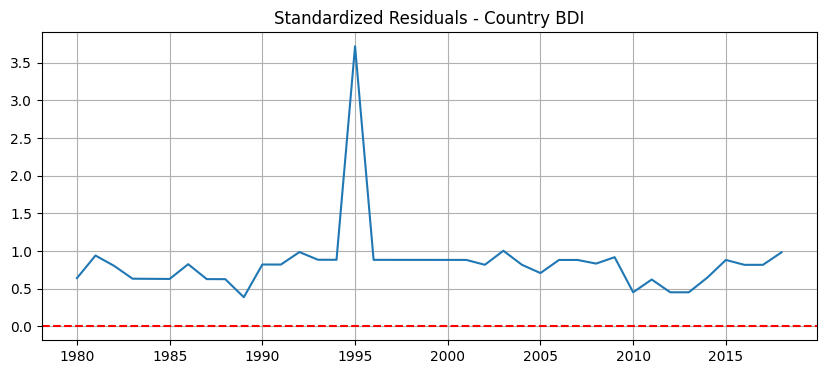


=== Country: BEL ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                94.4850
Distribution:                     Normal   AIC:                          -182.970
Method:               Maximum Likelihood   BIC:                          -177.979
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:12   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
-----------------------------------------------------------------------

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.982e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


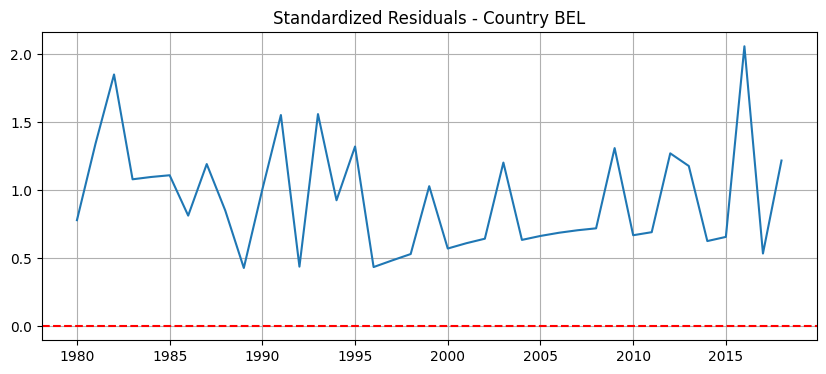

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001504. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



=== Country: BEN ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                73.0607
Distribution:                     Normal   AIC:                          -140.121
Method:               Maximum Likelihood   BIC:                          -135.131
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:12   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------

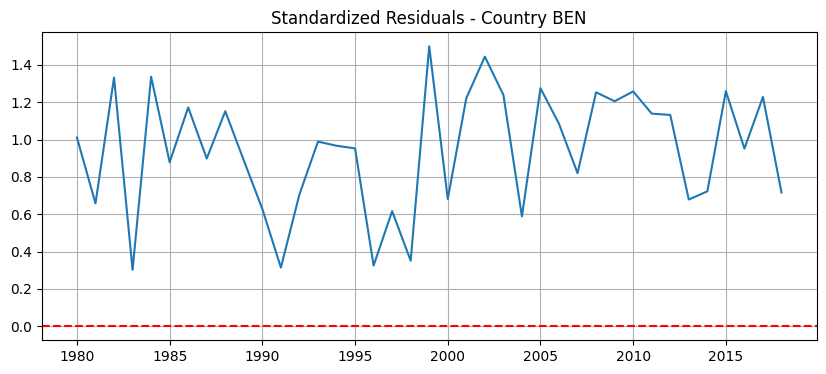


=== Country: BFA ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                55.8659
Distribution:                     Normal   AIC:                          -105.732
Method:               Maximum Likelihood   BIC:                          -100.741
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:12   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001952. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


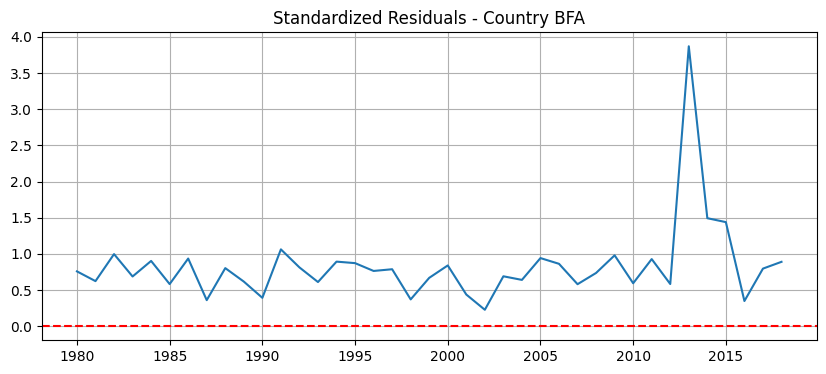

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001272. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



=== Country: BGD ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                54.9674
Distribution:                     Normal   AIC:                          -103.935
Method:               Maximum Likelihood   BIC:                          -98.9441
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:12   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------

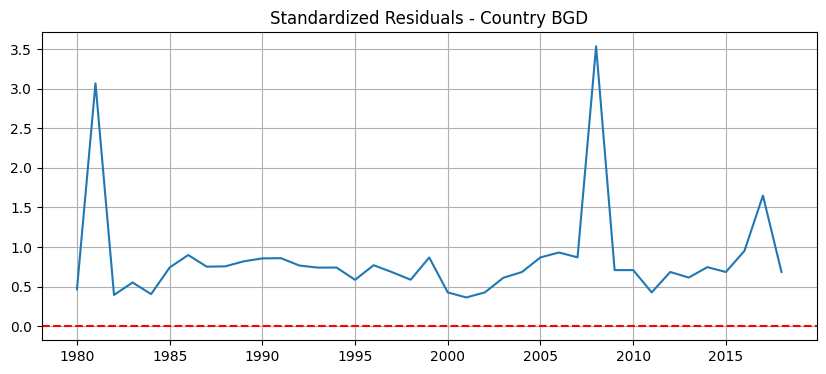

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001748. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



=== Country: BGR ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                84.5434
Distribution:                     Normal   AIC:                          -163.087
Method:               Maximum Likelihood   BIC:                          -158.096
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:12   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------

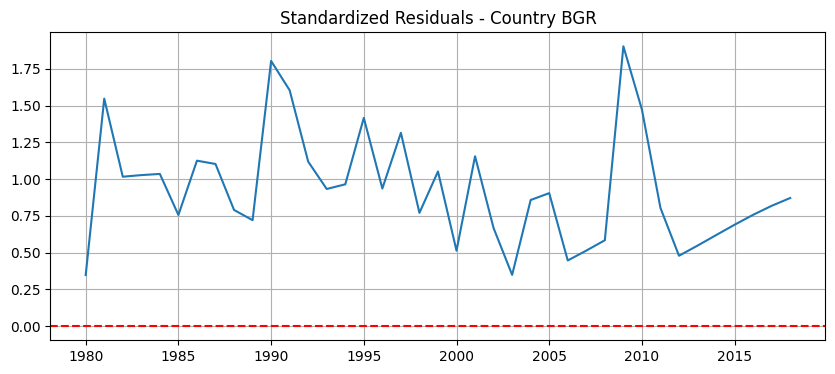


=== Country: BHR ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                81.8666
Distribution:                     Normal   AIC:                          -157.733
Method:               Maximum Likelihood   BIC:                          -152.743
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:12   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
-----------------------------------------------------------------------

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001204. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


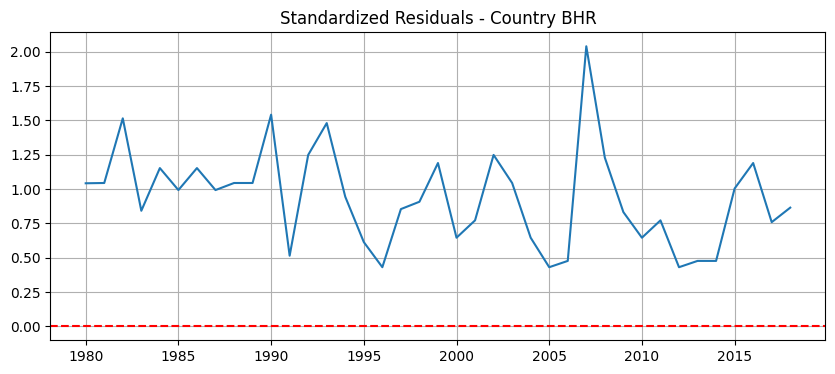

Not enough data points for country BIH, skipping.
Not enough data points for country BLR, skipping.

=== Country: BOL ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                79.3195
Distribution:                     Normal   AIC:                          -152.639
Method:               Maximum Likelihood   BIC:                          -147.648
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:13   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t    

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002216. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


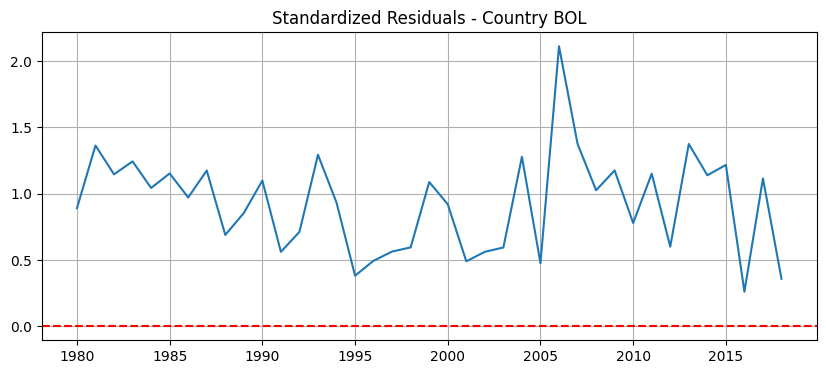


=== Country: BRA ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                76.5209
Distribution:                     Normal   AIC:                          -147.042
Method:               Maximum Likelihood   BIC:                          -142.051
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:13   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001607. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


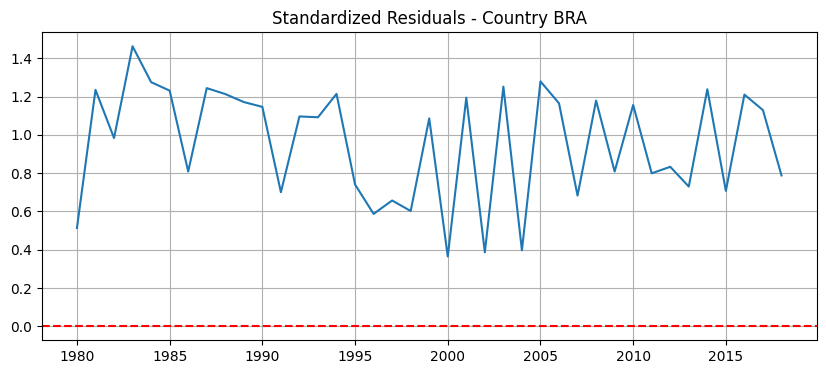

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001153. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



=== Country: BTN ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                55.8813
Distribution:                     Normal   AIC:                          -105.763
Method:               Maximum Likelihood   BIC:                          -100.772
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:13   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------

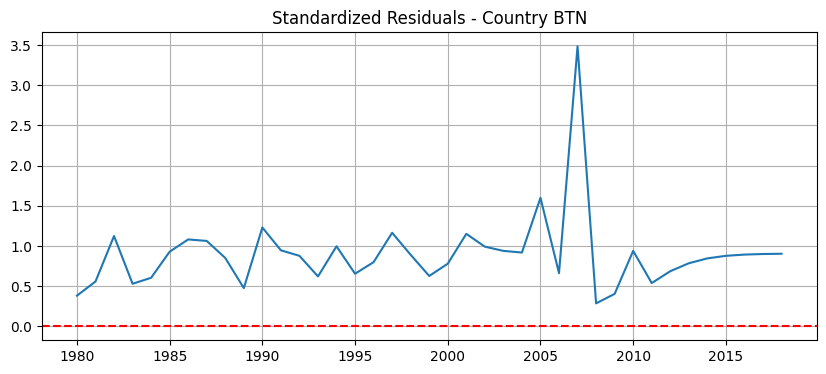

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.794e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



=== Country: BWA ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                69.9487
Distribution:                     Normal   AIC:                          -133.897
Method:               Maximum Likelihood   BIC:                          -128.907
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:13   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
-----------------------------------------------------------------------

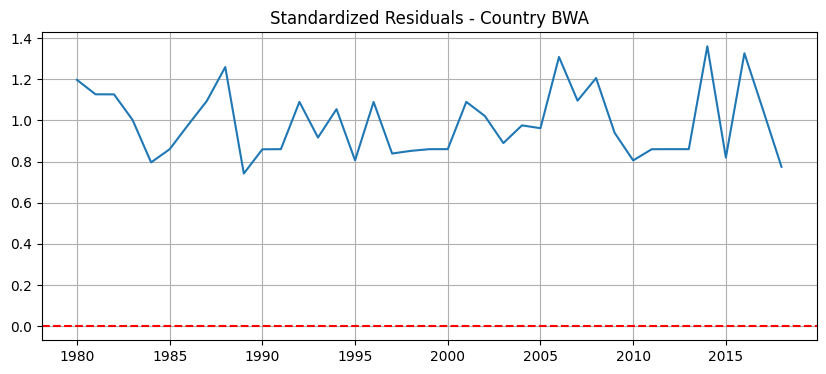

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00186. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



=== Country: CAF ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                52.2669
Distribution:                     Normal   AIC:                          -98.5337
Method:               Maximum Likelihood   BIC:                          -93.5431
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:13   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------

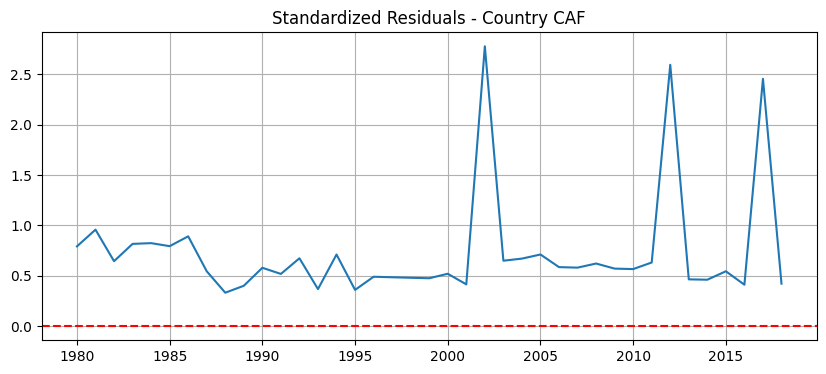

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001292. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



=== Country: CAN ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                93.1134
Distribution:                     Normal   AIC:                          -180.227
Method:               Maximum Likelihood   BIC:                          -175.236
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:13   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------

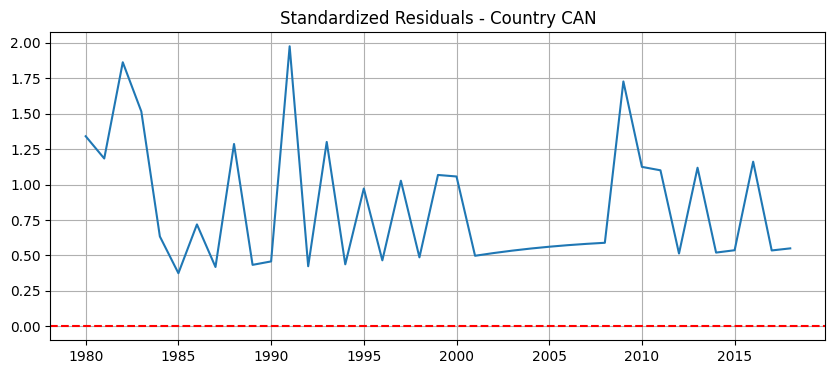

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000123. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



=== Country: CHE ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                89.5335
Distribution:                     Normal   AIC:                          -173.067
Method:               Maximum Likelihood   BIC:                          -168.076
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:13   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------

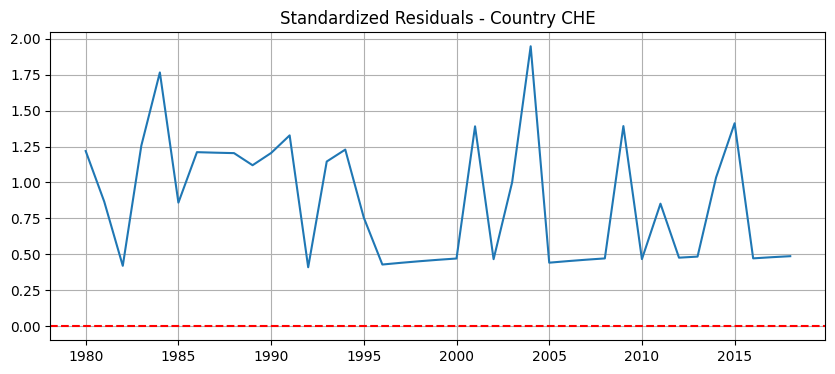

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001742. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



=== Country: CHL ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                89.8882
Distribution:                     Normal   AIC:                          -173.776
Method:               Maximum Likelihood   BIC:                          -168.786
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:13   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------

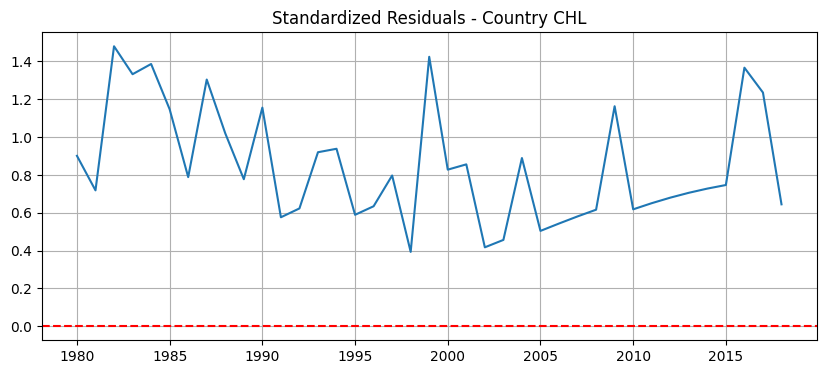

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001033. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



=== Country: CHN ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                74.1417
Distribution:                     Normal   AIC:                          -142.283
Method:               Maximum Likelihood   BIC:                          -137.293
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:14   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------

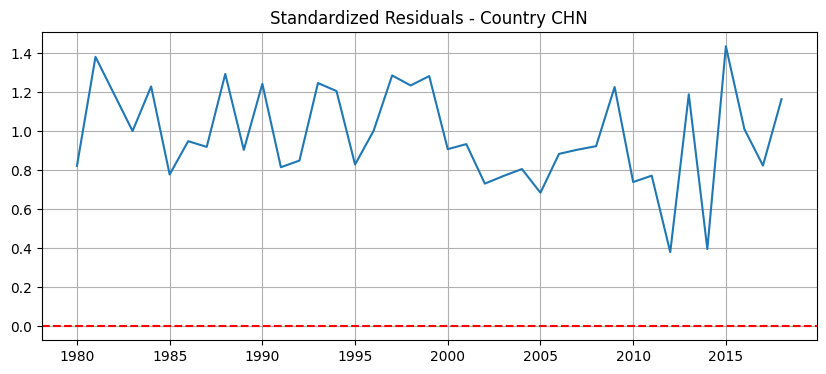

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0011. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



=== Country: CIV ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                60.7044
Distribution:                     Normal   AIC:                          -115.409
Method:               Maximum Likelihood   BIC:                          -110.418
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:14   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------

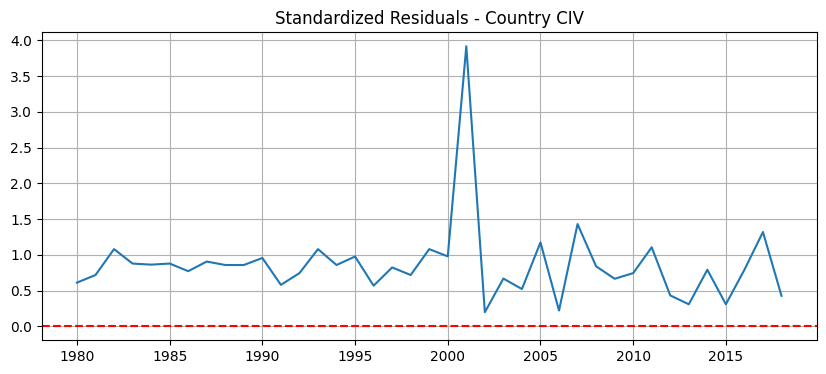

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001121. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



=== Country: CMR ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                74.9154
Distribution:                     Normal   AIC:                          -143.831
Method:               Maximum Likelihood   BIC:                          -138.840
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:14   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------

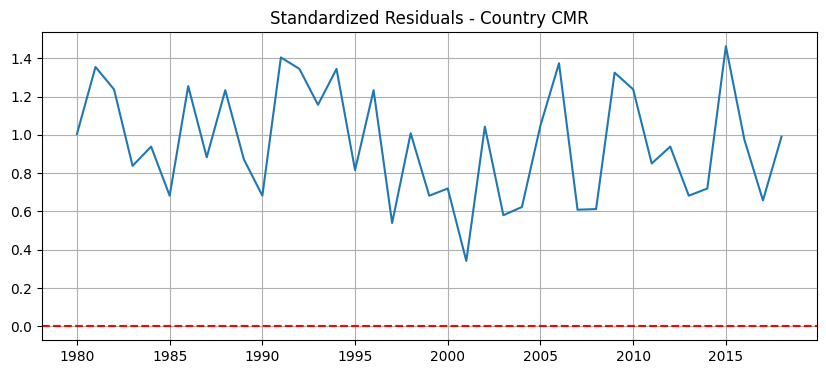

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001302. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



=== Country: COG ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                55.0493
Distribution:                     Normal   AIC:                          -104.099
Method:               Maximum Likelihood   BIC:                          -99.1080
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:14   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------

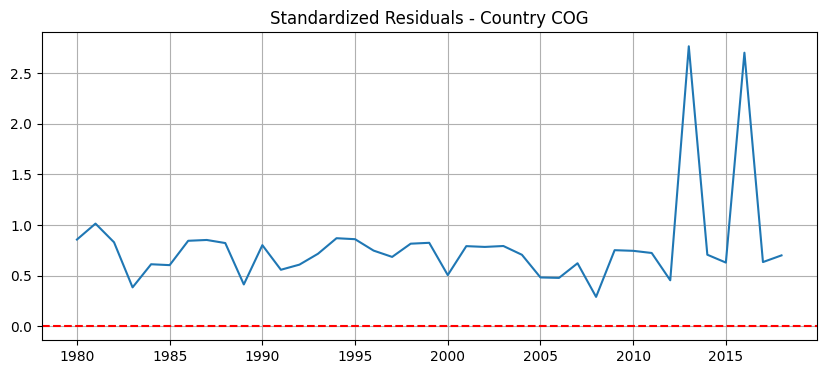

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000128. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



=== Country: COL ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                80.0368
Distribution:                     Normal   AIC:                          -154.074
Method:               Maximum Likelihood   BIC:                          -149.083
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:14   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------

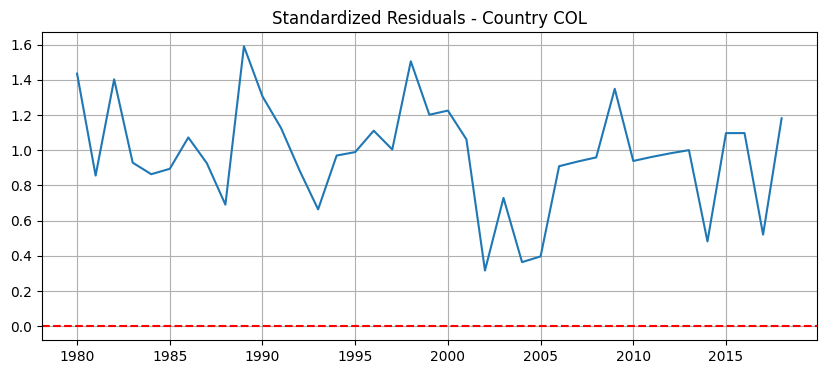


=== Country: COM ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                33.1778
Distribution:                     Normal   AIC:                          -60.3557
Method:               Maximum Likelihood   BIC:                          -55.3650
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:14   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006988. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


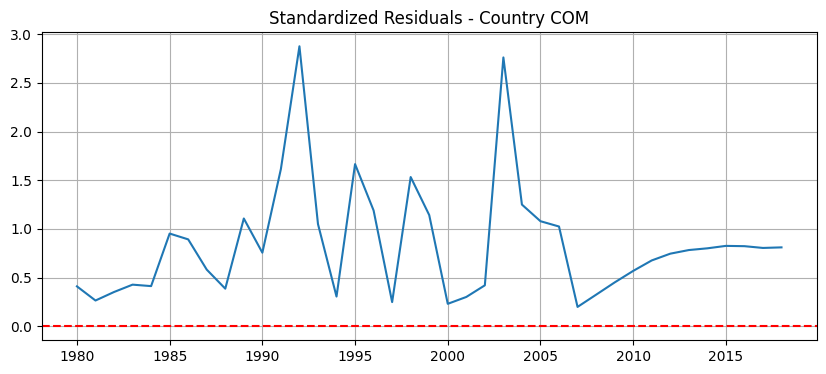

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.878e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



=== Country: CPV ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                68.9758
Distribution:                     Normal   AIC:                          -131.952
Method:               Maximum Likelihood   BIC:                          -126.961
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:14   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------

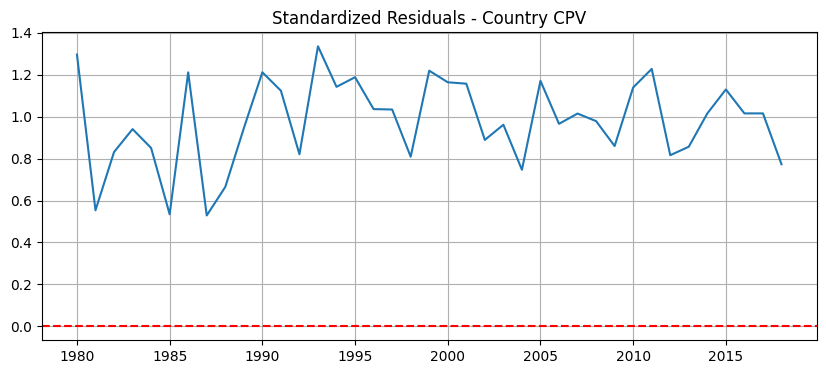

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002335. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



=== Country: CRI ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                84.8267
Distribution:                     Normal   AIC:                          -163.653
Method:               Maximum Likelihood   BIC:                          -158.663
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:15   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
-----------------------------------------------------------------------

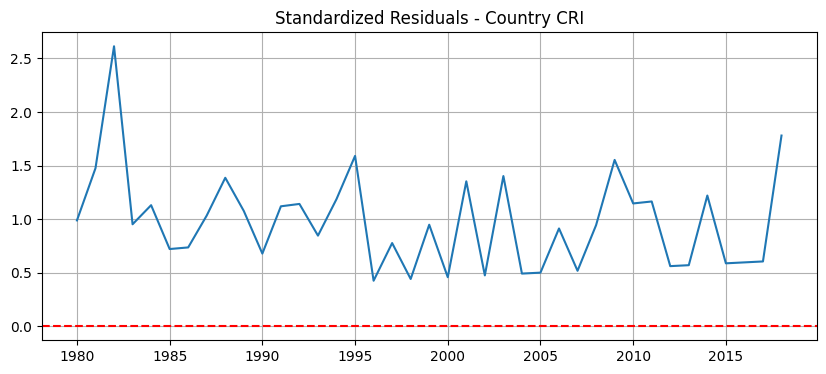


=== Country: CUB ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                89.4818
Distribution:                     Normal   AIC:                          -172.964
Method:               Maximum Likelihood   BIC:                          -167.973
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:15   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001384. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


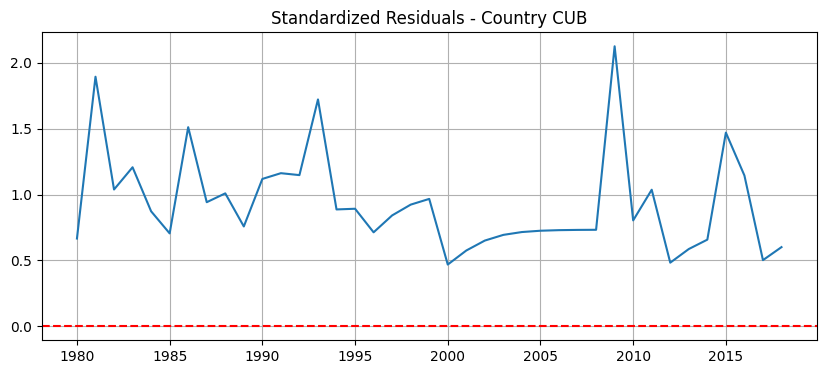

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001436. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



=== Country: CYP ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                85.8524
Distribution:                     Normal   AIC:                          -165.705
Method:               Maximum Likelihood   BIC:                          -160.714
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:15   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------

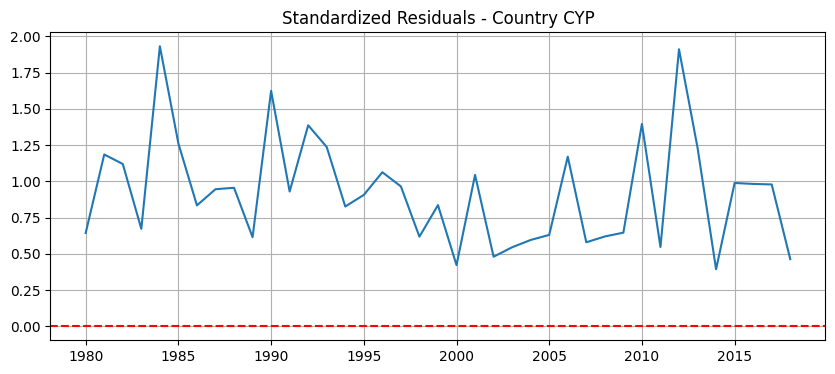

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003333. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Not enough data points for country CZE, skipping.
Not enough data points for country DEU, skipping.

=== Country: DJI ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.029
Vol Model:                         GARCH   Log-Likelihood:                43.5252
Distribution:                     Normal   AIC:                          -81.0504
Method:               Maximum Likelihood   BIC:                          -76.4713
                                           No. Observations:                   34
Date:                   Thu, Dec 19 2024   Df Residuals:                       34
Time:                           15:30:15   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t    

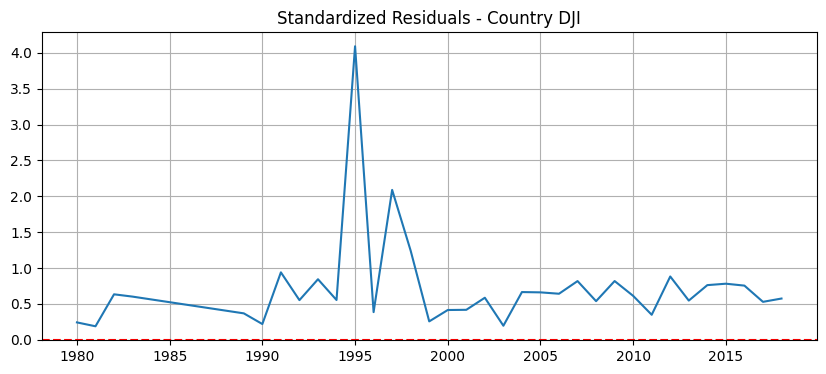

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.798e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



=== Country: DNK ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                96.3935
Distribution:                     Normal   AIC:                          -186.787
Method:               Maximum Likelihood   BIC:                          -181.796
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:15   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
-----------------------------------------------------------------------

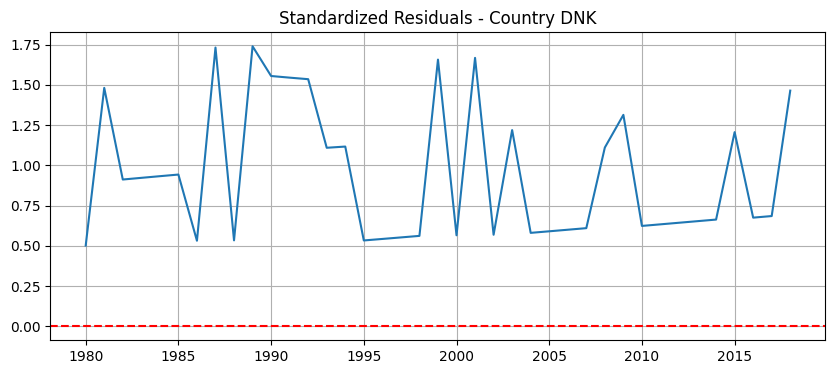

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001394. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



=== Country: DOM ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                80.0745
Distribution:                     Normal   AIC:                          -154.149
Method:               Maximum Likelihood   BIC:                          -149.158
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:15   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------

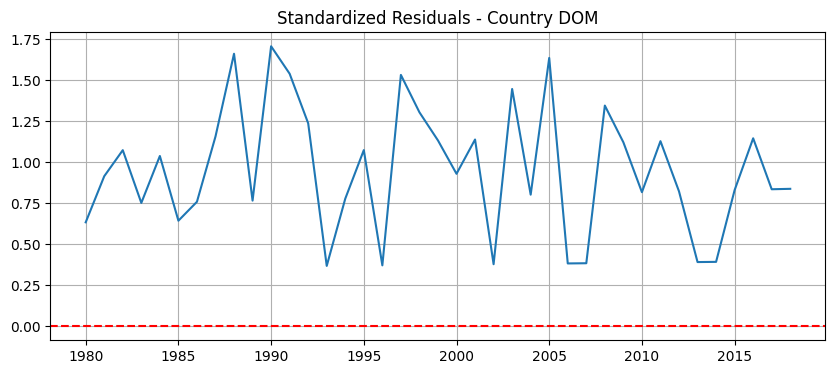

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.345e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



=== Country: DZA ===
Model Summary:
                         Zero Mean - GARCH Model Results                         
Dep. Variable:     predicted_probability   R-squared:                       0.000
Mean Model:                    Zero Mean   Adj. R-squared:                  0.026
Vol Model:                         GARCH   Log-Likelihood:                67.6629
Distribution:                     Normal   AIC:                          -129.326
Method:               Maximum Likelihood   BIC:                          -124.335
                                           No. Observations:                   39
Date:                   Thu, Dec 19 2024   Df Residuals:                       39
Time:                           15:30:15   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------

KeyboardInterrupt: 

In [ ]:
# Assume final_merged (or prob_df) has columns: 'Country_Code', 'Year', and 'predicted_probability'
# We'll do a groupby on Country_Code, and for each country:
# 1. Sort by Year
# 2. Extract the time series
# 3. Fit a GARCH model
# 4. Perform diagnostics
# 5. Print results

results_by_country = {}

# Group by country
for country, group in prob_df.groupby('ISO3'):
    # Sort by Year
    group = group.sort_values('Year')
    group = group.set_index('Year')

    ts = group['predicted_probability'].dropna()
    
    # If not enough data points, skip
    if len(ts) < 30:  # arbitrary minimum length for GARCH fitting
        print(f"Not enough data points for country {country}, skipping.")
        continue

    # Fit a GARCH(1,1) model
    model = arch_model(ts, mean='zero', vol='GARCH', p=1, q=1, dist='normal')
    res = model.fit(disp='off')

    print(f"\n=== Country: {country} ===")
    print("Model Summary:")
    print(res.summary())

    # Extract standardized residuals
    residuals = res.std_resid.dropna()

    # Check for autocorrelation in residuals (Ljung-Box test)
    ljung_box_results = acorr_ljungbox(residuals, lags=[10], return_df=True)

    # Check for remaining ARCH effects (ARCH-LM test)
    lm_test = het_arch(residuals)
    # lm_test returns (lm_stat, lm_pvalue, f_stat, f_pvalue)

    # Jarque-Bera test for normality
    jb_results = jarque_bera(residuals)
    # jarque_bera returns jb_stat and jb_pvalue in newer versions of scipy
    # If you're on a version that returns only two values:
    # jb_stat, jb_pvalue = jarque_bera(residuals)

    # Depending on your scipy version, jarque_bera might only return two values (stat, p-value)
    # Adjust accordingly:
    if len(jb_results) == 2:
        jb_stat, jb_pvalue = jb_results
        # For skew and kurtosis, compute separately if needed
        from scipy.stats import skew, kurtosis
        s = skew(residuals)
        k = kurtosis(residuals, fisher=False)
    else:
        # If older code assumed four returns
        jb_stat, jb_pvalue, s, k = jb_results

    # Print diagnostics
    print("\nDiagnostics:")
    print("Ljung-Box test (lag=10):")
    print(ljung_box_results)

    print("\nARCH-LM Test for residuals:")
    print("LM p-value:", lm_test[1], "F p-value:", lm_test[3])

    print("\nJarque-Bera Test:")
    print("JB p-value:", jb_pvalue)
    print("Skew:", s, "Kurtosis:", k)

    print("\nAIC:", res.aic)
    print("BIC:", res.bic)

    # Store results in dictionary if you want to analyze later
    results_by_country[country] = {
        'model_result': res,
        'ljung_box': ljung_box_results,
        'arch_lm': lm_test,
        'jb_pvalue': jb_pvalue,
        'skew': s,
        'kurtosis': k,
        'AIC': res.aic,
        'BIC': res.bic
    }

    # Optional: Plot residuals
    # plt.figure(figsize=(10,4))
    # plt.plot(residuals)
    # plt.title(f"Standardized Residuals - Country {country}")
    # plt.axhline(y=0, color='red', linestyle='--')
    # plt.grid(True)
    # plt.show()

# After the loop, results_by_country contains the GARCH fit and diagnostics for each country

In [46]:
# Identify columns that are years
year_columns = [col for col in plty_df.columns if col.isdigit()]

# Melt the entire Polity dataset (no filtering by Indicator)
melted_df_auto = plty_df.melt(
    id_vars=['Economy Name', 'Indicator'], 
    value_vars=year_columns, 
    var_name='Year', 
    value_name='Value'
)

# Convert Year and Value to numeric and drop missing
melted_df_auto['Year'] = pd.to_numeric(melted_df_auto['Year'], errors='coerce')
melted_df_auto = melted_df_auto.dropna(subset=['Year'])
melted_df_auto['Year'] = melted_df_auto['Year'].astype(int)

melted_df_auto['Value'] = pd.to_numeric(melted_df_auto['Value'], errors='coerce')
melted_df_auto = melted_df_auto.dropna(subset=['Value'])

# Standardize country names
def safe_upper_strip(x):
    if isinstance(x, str):
        return x.upper().strip()
    return np.nan

melted_df_auto['Economy_Name_standardized'] = melted_df_auto['Economy Name'].apply(safe_upper_strip)
cow_df['StateNme_standardized'] = cow_df['StateNme'].apply(safe_upper_strip)

melted_df_auto = melted_df_auto.dropna(subset=['Economy_Name_standardized'])
cow_df = cow_df.dropna(subset=['StateNme_standardized'])

# Map countries to their CCode
country_mapping = dict(zip(cow_df['StateNme_standardized'], cow_df['CCode']))
melted_df_auto['Country_Code'] = melted_df_auto['Economy_Name_standardized'].map(country_mapping)
melted_df_auto = melted_df_auto.dropna(subset=['Country_Code'])
melted_df_auto['Country_Code'] = melted_df_auto['Country_Code'].astype(int)

melted_df_auto = melted_df_auto[~(
    (melted_df_auto['Indicator'] == 'Polity database: Combined Polity Score') &
    ((melted_df_auto['Value'] < -10) | (melted_df_auto['Value'] > 10))
)]

# Ensure ties_df has numeric Country_Code and year
ties_df['Country_Code'] = pd.to_numeric(ties_df['targetstate'], errors='coerce')
ties_df = ties_df.dropna(subset=['Country_Code'])
ties_df['Country_Code'] = ties_df['Country_Code'].astype(int)

ties_df['startyear'] = pd.to_numeric(ties_df['startyear'], errors='coerce')
ties_df = ties_df.dropna(subset=['startyear'])
ties_df['startyear'] = ties_df['startyear'].astype(int)

# Pivot to get a multi-level column structure: columns = Indicator, Year
polity_wide = melted_df_auto.pivot_table(
    index='Country_Code', 
    columns=['Indicator','Year'], 
    values='Value'
)

# Define year offsets
year_offsets = range(-20, 21)

# For each row in ties_df, we extract polity scores for all indicators and all offsets
def get_polity_scores_for_row(row):
    ccode = row['Country_Code']
    event_year = row['startyear']
    if ccode not in polity_wide.index:
        # No polity data for this country
        return [np.nan] * (len(polity_wide.columns.levels[0]) * len(year_offsets))
    
    country_data = polity_wide.loc[ccode]
    all_values = []
    
    # Loop over each indicator
    for indicator in polity_wide.columns.levels[0]:
        # Get just this indicator's time series
        indicator_series = country_data[indicator]
        years_to_extract = [event_year + off for off in year_offsets]
        extracted = indicator_series.reindex(years_to_extract)
        all_values.extend(extracted.values)
    
    return all_values

# Create column names for all indicators and offsets
indicator_names = polity_wide.columns.levels[0]
all_columns = []
for ind in indicator_names:
    for offset in year_offsets:
        all_columns.append(f"{ind}_{offset}")

polity_scores = ties_df.apply(get_polity_scores_for_row, axis=1)
polity_scores_df = pd.DataFrame(polity_scores.tolist(), columns=all_columns, index=ties_df.index)

# Concatenate these columns with the original ties_df
final_df = pd.concat([ties_df, polity_scores_df], axis=1)

In [122]:
# Create a mapping from ISO3 (StateAbb) to CCode using cow_df
iso3_to_ccode = dict(zip(cow_df['StateAbb'], cow_df['CCode']))

# Add a column for last year's prediction to prob_df
prob_df['Year_prev'] = prob_df['Year'] - 1

# Map ISO3 to Country_Code using the iso3_to_ccode dictionary
prob_df['Country_Code'] = prob_df['ISO3'].map(iso3_to_ccode)

# Drop rows where mapping failed (no ISO3 match in cow_df)
prob_df = prob_df.dropna(subset=['Country_Code'])

# Ensure Country_Code is integer
prob_df['Country_Code'] = prob_df['Country_Code'].astype(int)

# Merge current year predicted_probability
final_merged = pd.merge(
    final_df,
    prob_df[['Country_Code', 'Year', 'predicted_probability']], 
    left_on=['Country_Code', 'startyear'],
    right_on=['Country_Code', 'Year'],
    how='left'
)

# Rename current year's predicted probability column
final_merged = final_merged.rename(columns={'predicted_probability': 'predicted_probability_t'})

# Merge last year's predicted_probability
final_merged = pd.merge(
    final_merged,
    prob_df[['Country_Code', 'Year_prev', 'predicted_probability']], 
    left_on=['Country_Code', 'startyear'],
    right_on=['Country_Code', 'Year_prev'],
    how='left'
)

# Rename last year's predicted probability column
final_merged = final_merged.rename(columns={'predicted_probability': 'predicted_probability_tminus1'})

# Drop unnecessary columns
final_merged = final_merged.drop(columns=['Year', 'Year_prev'], errors='ignore')


In [123]:
final_merged = final_merged[final_merged['startyear'] >= 1980]

In [139]:
target = "predicted_probability_t"

final_merged = final_merged.dropna(subset=[target])
final_merged = final_merged.dropna(subset=['predicted_probability_tminus1'])

### General

In [152]:
# 1. Compute the average predicted probability per year
yearly_avg = prob_df.groupby('Year')['predicted_probability'].mean()

# `yearly_avg` is now a Series indexed by Year with the average predicted_probability for each year.

# 2. Compute the yearly delta (the difference between each year's average and the previous year's average)
yearly_delta = yearly_avg.diff()

# 3. Compute the average delta across all years
avg_delta_per_year = yearly_delta.mean()

print("Average predicted probability per year:\n", yearly_avg)
print("\nAverage year-over-year delta:", avg_delta_per_year)

Average predicted probability per year:
 Year
1980    0.036316
1981    0.036181
1982    0.038356
1983    0.037305
1984    0.041145
1985    0.036402
1986    0.037799
1987    0.038435
1988    0.044901
1989    0.035344
1990    0.039872
1991    0.041821
1992    0.043947
1993    0.055081
1994    0.037821
1995    0.043426
1996    0.033394
1997    0.038550
1998    0.039738
1999    0.048581
2000    0.034100
2001    0.033471
2002    0.036841
2003    0.038480
2004    0.032111
2005    0.039987
2006    0.038540
2007    0.035115
2008    0.038533
2009    0.039694
2010    0.035883
2011    0.033577
2012    0.032678
2013    0.032652
2014    0.031045
2015    0.032990
2016    0.035342
2017    0.031788
2018    0.030363
Name: predicted_probability, dtype: float64

Average year-over-year delta: -0.00015667152918161752


In [157]:
# 1. Compute yearly average predicted probability from prob_df
yearly_avg = prob_df.groupby('Year')['predicted_probability'].mean()

# 2. Compute the global year-over-year delta and its average
yearly_delta = yearly_avg.diff()
avg_delta_per_year = yearly_delta.mean()

# 3. Create a new DataFrame from final_merged to hold the raw delta and adjusted delta
new_df = pd.DataFrame({
    'Year': final_merged['startyear'],
    'predicted_probability_t': final_merged['predicted_probability_t'],
    'predicted_probability_tminus1': final_merged['predicted_probability_tminus1']
})

# Compute the raw delta per row
new_df['raw_delta'] = new_df['predicted_probability_t'] - new_df['predicted_probability_tminus1']

# 4. Adjust by subtracting the global average yearly delta
new_df['adjusted_delta'] = new_df['raw_delta'] - avg_delta_per_year

# Now you can inspect the adjusted deltas
print(new_df['adjusted_delta'].describe())

count    551.000000
mean       0.002739
std        0.029506
min       -0.214322
25%       -0.005181
50%        0.000157
75%        0.010223
max        0.202116
Name: adjusted_delta, dtype: float64


In [160]:
for i in final_merged.columns:
    print(i)

caseid
startmonth
startday
startyear
endmonth
endday
endyear
ongoingasofmonth
ongoingasofday
ongoingasofyear
sender1
sender2
sender3
sender4
sender5
primarysender
targetstate
institution
institutionid
targetinstitution
otherinstitution
issue1
issue2
issue3
otherissue
threat
threatid1
threatid2
threatid3
sanctiontypethreat
othersanctiontypethreatened
bspecif
scommit
threatenedtargetinterest
dsanctions
carrots
anticipatedtargetcosts
anticipatedtargetcostsfigureifav
tcurrency
tyearofestimate
anticipatedsendercosts
scurrency
syearofestimate
imposition
sancimpositionstartmonth
sancimpositionstartday
sancimpositionstartyear
sanctionidentity
sanctiontype
othersanctiontype
implementationofdiplomaticsancti
carrotsduringsanction
carrotvalue
carrotcurrency
carrotyear
targetcosts
targeteconomiccostsfigure
targeteconomiccostscurrency
targeteconomiccostsyear
sendercosts
sendereconomiccostsfigure
sendereconomiccostscurrency
sendereconomiccostsyear
finaloutcome
settlementnaturesender
settlementnaturet

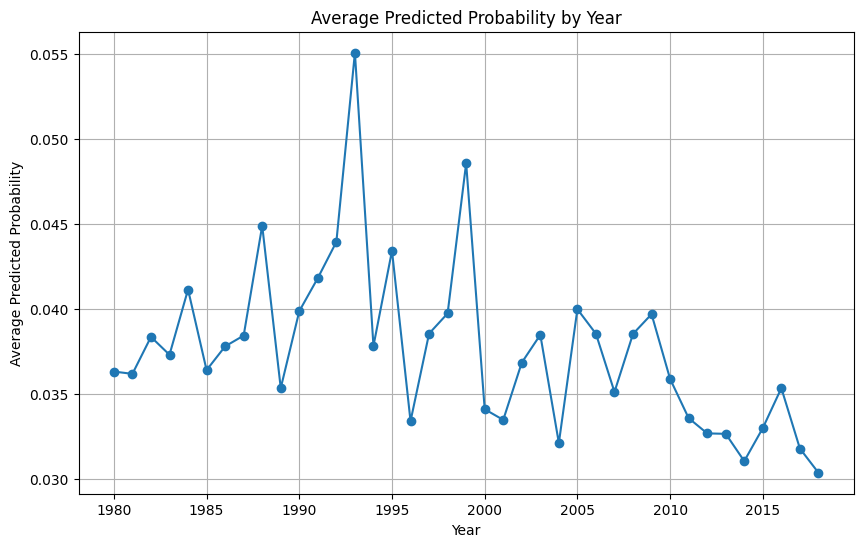

In [138]:
# Group by Year and calculate mean predicted_probability
yearly_avg = prob_df.groupby('Year')['predicted_probability'].mean()

# Plot the yearly average predicted probability
plt.figure(figsize=(10,6))
yearly_avg.plot(kind='line', marker='o')
plt.title('Average Predicted Probability by Year')
plt.xlabel('Year')
plt.ylabel('Average Predicted Probability')
plt.grid(True)
plt.show()

In [144]:
# Threat
(analysis_df['predicted_probability_t'] - analysis_df['predicted_probability_tminus1']).describe()

count    229.000000
mean       0.003158
std        0.020797
min       -0.038889
25%       -0.005338
50%        0.000000
75%        0.009839
max        0.201960
dtype: float64

   finaloutcome      mean       std  count       sem  ci_lower  ci_upper
0           1.0  0.011177  0.044119     23  0.009199 -0.006854  0.029207
1           2.0  0.007410  0.028582     36  0.004764 -0.001927  0.016747
2           3.0  0.001207  0.010567     71  0.001254 -0.001251  0.003665
3           4.0  0.001561  0.010404      9  0.003468 -0.005236  0.008358
4           5.0 -0.001964  0.008782     28  0.001660 -0.005217  0.001289
5           6.0  0.001137  0.014917     21  0.003255 -0.005243  0.007517
6           7.0  0.003065  0.014342     24  0.002928 -0.002673  0.008803
7           8.0 -0.004544  0.028232     56  0.003773 -0.011938  0.002850
8           9.0  0.009871  0.039258     29  0.007290 -0.004417  0.024159
9          10.0  0.000963  0.031750     55  0.004281 -0.007428  0.009354


C:\Users\maxla\AppData\Local\Temp\ipykernel_51168\1676881099.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='finaloutcome', y='mean', data=group_stats, join=False, ci=None, color='blue')
C:\Users\maxla\AppData\Local\Temp\ipykernel_51168\1676881099.py:35: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='finaloutcome', y='mean', data=group_stats, join=False, ci=None, color='blue')


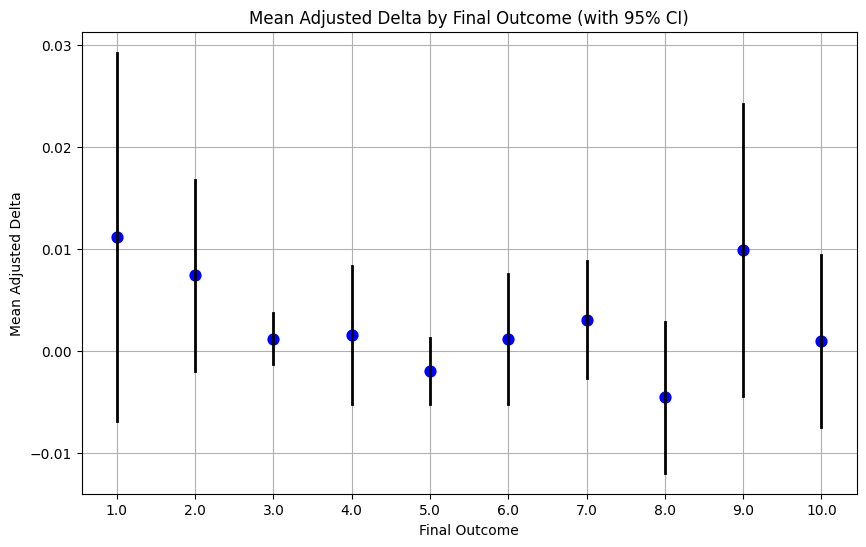

In [170]:
# 1. Compute the global average yearly predicted probability from prob_df
yearly_avg = prob_df.groupby('Year')['predicted_probability'].mean()

# Compute the yearly deltas from the global average
yearly_delta = yearly_avg.diff()

# Compute the average delta per year
avg_delta_per_year = yearly_delta.mean()

# 2. Create the adjusted_delta column in final_merged
final_merged['adjusted_delta'] = (final_merged['predicted_probability_t'] 
                                  - final_merged['predicted_probability_tminus1']
                                  - avg_delta_per_year)

# 3. Create a new DataFrame that groups by Final_Outcome and computes statistics
new_df = final_merged[['finaloutcome', 'adjusted_delta']].copy()

group_stats = new_df.groupby('finaloutcome')['adjusted_delta'].agg(['mean', 'std', 'count'])

# Compute standard error and 95% CI
group_stats['sem'] = group_stats['std'] / np.sqrt(group_stats['count'])
z_value = 1.96
group_stats['ci_lower'] = group_stats['mean'] - z_value * group_stats['sem']
group_stats['ci_upper'] = group_stats['mean'] + z_value * group_stats['sem']

group_stats = group_stats.reset_index()

# Print the resulting DataFrame
print(group_stats)

# 4. Plot the means with 95% CI
plt.figure(figsize=(10, 6))

# sns.pointplot will treat 'finaloutcome' as categorical and position them at 0,1,2,...
sns.pointplot(x='finaloutcome', y='mean', data=group_stats, join=False, ci=None, color='blue')

# Add the computed error bars using the loop index 'i'
for i, row in group_stats.iterrows():
    plt.plot([i, i], [row['ci_lower'], row['ci_upper']], color='black', linewidth=2)

plt.title('Mean Adjusted Delta by Final Outcome (with 95% CI)')
plt.xlabel('Final Outcome')
plt.ylabel('Mean Adjusted Delta')
plt.grid(True)
plt.show()

              Outcome_Group      mean       std  count       sem  ci_lower  \
0                     Other  0.003810  0.034665    199  0.002457 -0.001006   
1  Post-Sanction Compliance  0.001504  0.025365    100  0.002536 -0.003468   
2     Post-Sanction Failure  0.000374  0.032907     85  0.003569 -0.006622   
3   Pre-Sanction Compliance  0.005389  0.029713     87  0.003186 -0.000855   
4      Pre-Sanction Failure  0.001247  0.010484     80  0.001172 -0.001051   

   ci_upper  
0  0.008627  
1  0.006475  
2  0.007370  
3  0.011633  
4  0.003544  


C:\Users\maxla\AppData\Local\Temp\ipykernel_51168\3593415757.py:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='Outcome_Group', y='mean', data=group_stats, order=category_order, join=False, ci=None, color='blue')
C:\Users\maxla\AppData\Local\Temp\ipykernel_51168\3593415757.py:55: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='Outcome_Group', y='mean', data=group_stats, order=category_order, join=False, ci=None, color='blue')


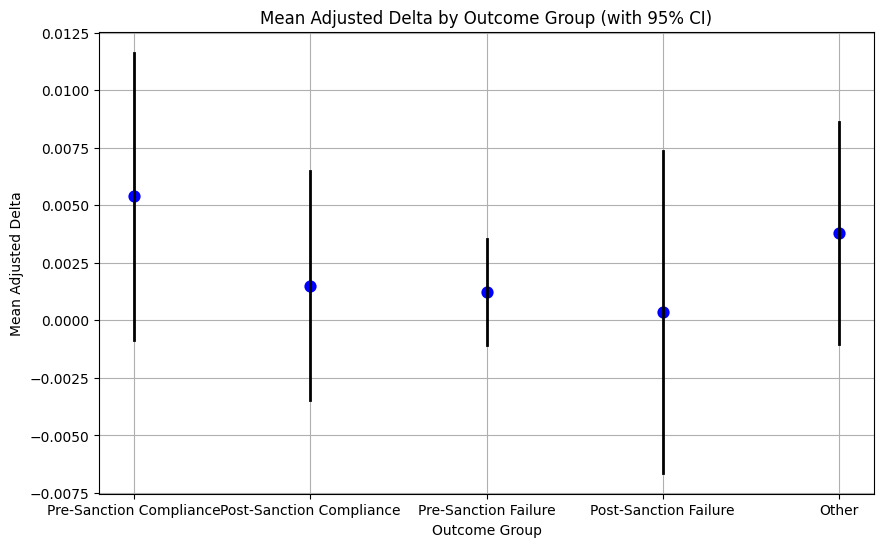

In [172]:
# 1. Compute global avg delta per year from prob_df
yearly_avg = prob_df.groupby('Year')['predicted_probability'].mean()
yearly_delta = yearly_avg.diff()
avg_delta_per_year = yearly_delta.mean()

# 2. Create adjusted_delta in final_merged
final_merged['adjusted_delta'] = (
    final_merged['predicted_probability_t'] 
    - final_merged['predicted_probability_tminus1']
    - avg_delta_per_year
)

# Define the outcome groups according to the chosen scheme
pre_compliance = [1, 2, 5]
post_compliance = [6, 7, 10]
pre_failure = [3, 4]
post_failure = [8, 9]

def categorize_outcome(outcome):
    if outcome in pre_compliance:
        return 'Pre-Sanction Compliance'
    elif outcome in post_compliance:
        return 'Post-Sanction Compliance'
    elif outcome in pre_failure:
        return 'Pre-Sanction Failure'
    elif outcome in post_failure:
        return 'Post-Sanction Failure'
    else:
        return 'Other'
    

# 3. Create a new column for the 4-group scheme
final_merged['Outcome_Group'] = final_merged['finaloutcome'].apply(categorize_outcome)

# 4. Compute statistics by these four groups
new_df = final_merged[['Outcome_Group', 'adjusted_delta']].copy()
group_stats = new_df.groupby('Outcome_Group')['adjusted_delta'].agg(['mean', 'std', 'count'])

# Compute SEM and 95% CI
group_stats['sem'] = group_stats['std'] / np.sqrt(group_stats['count'])
z_value = 1.96
group_stats['ci_lower'] = group_stats['mean'] - z_value * group_stats['sem']
group_stats['ci_upper'] = group_stats['mean'] + z_value * group_stats['sem']

group_stats = group_stats.reset_index()

print(group_stats)

# 5. Plot the means with 95% CI
plt.figure(figsize=(10, 6))

# Sort the categories if desired for a logical plot order
category_order = ['Pre-Sanction Compliance', 'Post-Sanction Compliance', 'Pre-Sanction Failure', 'Post-Sanction Failure', 'Other']

sns.pointplot(x='Outcome_Group', y='mean', data=group_stats, order=category_order, join=False, ci=None, color='blue')

# Add CI error bars
for i, row in group_stats.iterrows():
    # Find the x-position from the category_order
    x_pos = category_order.index(row['Outcome_Group'])
    plt.plot([x_pos, x_pos], [row['ci_lower'], row['ci_upper']], color='black', linewidth=2)

plt.title('Mean Adjusted Delta by Outcome Group (with 95% CI)')
plt.xlabel('Outcome Group')
plt.ylabel('Mean Adjusted Delta')
plt.grid(True)
plt.show()

In [179]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# We assume new_df has at least these four groups:
# 'Pre-Sanction Compliance'
# 'Post-Sanction Compliance'
# 'Pre-Sanction Failure'
# 'Post-Sanction Failure'

# Extract the data for each group
groups = ['Pre-Sanction Compliance', 'Post-Sanction Compliance', 'Pre-Sanction Failure', 'Post-Sanction Failure']
group_data = [new_df[new_df['Outcome_Group'] == g]['adjusted_delta'] for g in groups]

# 1. Perform a one-way ANOVA
f_stat, p_value = f_oneway(*group_data)
print("One-way ANOVA Results:")
print("F-statistic:", f_stat)
print("p-value:", p_value)

# If p-value < 0.05, we reject the null that all group means are equal.
# Proceed with Tukey's HSD for post-hoc analysis.

# 2. Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=new_df['adjusted_delta'],  # data
                          groups=new_df['Outcome_Group'],   # groups
                          alpha=0.05)                       # significance level

print("\nTukey's HSD Post-Hoc Results:")
print(tukey)

One-way ANOVA Results:
F-statistic: 0.6242755881517756
p-value: 0.5997181138209694

Tukey's HSD Post-Hoc Results:
                  Multiple Comparison of Means - Tukey HSD, FWER=0.05                  
         group1                   group2          meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------------------------
                   Other Post-Sanction Compliance  -0.0023 0.9691 -0.0122 0.0076  False
                   Other    Post-Sanction Failure  -0.0034  0.898 -0.0139  0.007  False
                   Other  Pre-Sanction Compliance   0.0016 0.9937 -0.0088  0.012  False
                   Other     Pre-Sanction Failure  -0.0026 0.9657 -0.0133 0.0081  False
Post-Sanction Compliance    Post-Sanction Failure  -0.0011  0.999 -0.0131 0.0108  False
Post-Sanction Compliance  Pre-Sanction Compliance   0.0039 0.8982  -0.008 0.0157  False
Post-Sanction Compliance     Pre-Sanction Failure  -0.0003    1.0 -0.0124 0.0119  False
   Pos

### Threat Impact on Stability

In [142]:

# Start from the updated analysis_df as in the original code
analysis_df = final_merged.copy()

analysis_df = analysis_df.dropna(subset=['settlementnaturesender'])
analysis_df = analysis_df[analysis_df['imposition'] != 'Missing']

analysis_df = analysis_df[
    (analysis_df['startyear'] != analysis_df['sancimpositionstartyear']) |
    (analysis_df['startmonth'] != analysis_df['sancimpositionstartmonth']) |
    (analysis_df['startday'] != analysis_df['sancimpositionstartday'])
]

# Identify polity -1 year variables
# polity_minus_one_vars = [col for col in analysis_df.columns if col.endswith('_-1')]
polity_minus_one_vars = []

# Listed TIES features (original + newly added)
ties_features = [
    'issue1', 'threatid1', 'sanctiontypethreat', 'bspecif', 'scommit',
    'threatenedtargetinterest', 'carrots', 'anticipatedtargetcosts',
    'anticipatedsendercosts',
    'institution',  # Categorical
    'targetinstitution',  # Categorical
    'othersanctiontypethreatened', # Categorical
    'dsanctions' # Categorical
]

all_features = polity_minus_one_vars + ties_features

# Check which features exist
final_features = []
for f in all_features:
    if f not in analysis_df.columns:
        print(f"Feature '{f}' not found, skipping it.")
    else:
        final_features.append(f)

if not final_features:
    raise ValueError("No features available after checking existence. Please revise variable selection.")

# Ensure that both predicted_probability_t (current year) and predicted_probability_tminus1 (previous year) exist
if 'predicted_probability_t' not in analysis_df.columns:
    raise ValueError("'predicted_probability_t' column not found in the DataFrame.")
if 'predicted_probability_tminus1' not in analysis_df.columns:
    raise ValueError("'predicted_probability_tminus1' column not found in the DataFrame.")

# We will not use predicted probabilities as features. Just ensure they exist to compute pct change.
# Keep only final_features plus the needed predicted probabilities
analysis_df = analysis_df[final_features + ['predicted_probability_t', 'predicted_probability_tminus1']]

# Attempt to convert identified vars to numeric if possible
vars_to_process = final_features + ['settlementnaturesender']
for var in vars_to_process:
    if var in analysis_df.columns:
        analysis_df[var] = pd.to_numeric(analysis_df[var], errors='coerce')

# Treat ties_features as categorical
for var in ties_features:
    if var in analysis_df.columns:
        # Convert all entries to string to ensure consistency
        analysis_df[var] = analysis_df[var].astype(str).astype('category')
        # Add a "Missing" category to handle NaN explicitly if needed
        if "Missing" not in analysis_df[var].cat.categories:
            analysis_df[var] = analysis_df[var].cat.add_categories(["Missing"])
        analysis_df[var] = analysis_df[var].fillna("Missing")

# For polity_minus_one_vars, median-impute missing values
for var in polity_minus_one_vars:
    if var in analysis_df.columns:
        col_median = analysis_df[var].median()
        analysis_df[var] = analysis_df[var].fillna(col_median)

# Custom parsing function for any remaining non-numeric columns not in ties_features
def parse_numeric_string(val):
    if pd.isna(val):
        return val
    s = str(val)
    try:
        return float(s)
    except ValueError:
        # If conversion fails, try space-separated values
        parts = s.split()
        if len(parts) == 2:
            try:
                num1, num2 = float(parts[0]), float(parts[1])
                return (num1 + num2)/2.0
            except ValueError:
                return np.nan
        return np.nan

non_numeric_cols = analysis_df.select_dtypes(include=['object']).columns
for col in non_numeric_cols:
    if col not in ties_features:
        analysis_df[col] = analysis_df[col].apply(parse_numeric_string)
        # Try converting to numeric again
        analysis_df[col] = pd.to_numeric(analysis_df[col], errors='coerce')

# Remove columns that are entirely NaN
for var in list(final_features):
    if var not in analysis_df.columns:
        continue
    if analysis_df[var].isna().all():
        print(f"Feature '{var}' is all NaN, removing it.")
        final_features.remove(var)

if not final_features:
    raise ValueError("No usable features remain after removing all-NaN columns.")

# Define numerical and categorical features
numerical_features = [f for f in final_features if f in polity_minus_one_vars]
categorical_features = [f for f in ties_features if f in final_features]

# Compute the percentage change in predicted probability
# Drop rows where predicted_probability_tminus1 is zero or NaN to avoid division by zero
analysis_df = analysis_df.dropna(subset=['predicted_probability_tminus1'])
analysis_df = analysis_df[analysis_df['predicted_probability_tminus1'] != 0]

analysis_df['pct_change_pred_prob'] = (
    (analysis_df['predicted_probability_t'] - analysis_df['predicted_probability_tminus1']) /
    analysis_df['predicted_probability_tminus1']
)

# Our target is now the pct change in predicted probability
y = analysis_df['pct_change_pred_prob']

# Remove predicted_probability_t and predicted_probability_tminus1 from features
# We do not want to use them as predictors
X = analysis_df[numerical_features + categorical_features]

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=0.90))  # Retain 90% of variance
        ]), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

pipeline_prob_impose = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Fit the pipeline on training data
pipeline_prob_impose.fit(X_train, y_train)

# Evaluate the model
train_score = pipeline_prob_impose.score(X_train, y_train)
test_score = pipeline_prob_impose.score(X_test, y_test)

print("Number of observations:", len(analysis_df))

onehot_feature_names = pipeline_prob_impose.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
print("Number of features after encoding:", len(numerical_features) + onehot_feature_names.shape[0])
print("Training R-squared:", train_score)
print("Test R-squared:", test_score)

# Predict pct change in probability on the test set
y_pred = pipeline_prob_impose.predict(X_test)

# Evaluate regression performance using MSE and R²:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R-squared:", r2)

Number of observations: 229
Number of features after encoding: 55
Training R-squared: 0.26296923192900235
Test R-squared: -0.7898932312026534
MSE: 0.8200652716321477
R-squared: -0.7898932312026534


c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [161]:
# Assume analysis_df, numerical_features, categorical_features, and y are defined as above.

# Create a copy of the dataframe for X
X = analysis_df[numerical_features + categorical_features].copy()

# Convert categorical variables into dummy variables
X = pd.get_dummies(X, drop_first=True)

# Ensure y is numeric
y = pd.to_numeric(y, errors='coerce')

# Convert all remaining columns in X to numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Align indices of X and y and drop any rows with NaN
X, y = X.align(y, join='inner', axis=0)
X = X.dropna(axis=0, how='any')
y = y.loc[X.index]

# Double-check that all dtypes are numeric
print(X.dtypes)  # Should show float or int types
print(y.dtypes)  # Should be float

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit()

# Print the summary of the model
print(results.summary())

const                                  float64
issue1_10                                 bool
issue1_11                                 bool
issue1_12                                 bool
issue1_13                                 bool
                                        ...   
othersanctiontypethreatened_Missing       bool
dsanctions_2.0                            bool
dsanctions_4.0                            bool
dsanctions_nan                            bool
dsanctions_Missing                        bool
Length: 70, dtype: object
float64


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [121]:
# Start with final_merged which must contain final_features, predicted_probability_t, predicted_probability_tplus1, etc.
analysis_df = final_merged.copy()

analysis_df = analysis_df.dropna(subset=['settlementnaturesender'])
analysis_df = analysis_df[analysis_df['imposition'] != 'Missing']

analysis_df = analysis_df[
    (analysis_df['startyear'] != analysis_df['sancimpositionstartyear']) |
    (analysis_df['startmonth'] != analysis_df['sancimpositionstartmonth']) |
    (analysis_df['startday'] != analysis_df['sancimpositionstartday'])
]

# Identify polity -1 year variables
# polity_minus_one_vars = [col for col in analysis_df.columns if col.endswith('_-1')]
polity_minus_one_vars = []

# Listed TIES features (original + newly added)
ties_features = [
    'issue1', 'threatid1', 'sanctiontypethreat', 'bspecif', 'scommit',
    'threatenedtargetinterest', 'carrots', 'anticipatedtargetcosts',
    'anticipatedsendercosts',
    'institution',  # Categorical
    'targetinstitution',  # Categorical
    'othersanctiontypethreatened', # Categorical
    'dsanctions' # Categorical
]

all_features = polity_minus_one_vars + ties_features

final_features = [f for f in all_features if f in analysis_df.columns]
if not final_features:
    raise ValueError("No features available after checking existence. Please revise variable selection.")

if 'predicted_probability_t' not in analysis_df.columns:
    raise ValueError("'predicted_probability_t' column not found.")
if 'predicted_probability_tminus1' not in analysis_df.columns:
    raise ValueError("'predicted_probability_tplus1' column not found.")

analysis_df = analysis_df[final_features + ['predicted_probability_t', 'predicted_probability_tplus1']]

# Convert to numeric where appropriate
for var in final_features:
    analysis_df[var] = pd.to_numeric(analysis_df[var], errors='coerce')

# Treat ties_features as categorical
for var in ties_features:
    if var in analysis_df.columns:
        analysis_df[var] = analysis_df[var].astype(str).astype('category')
        if "Missing" not in analysis_df[var].cat.categories:
            analysis_df[var] = analysis_df[var].cat.add_categories(["Missing"])
        analysis_df[var] = analysis_df[var].fillna("Missing")

# Median-impute numeric polity vars
for var in polity_minus_one_vars:
    if var in analysis_df.columns:
        median_val = analysis_df[var].median()
        analysis_df[var] = analysis_df[var].fillna(median_val)

# Remove columns that are entirely NaN
for var in list(final_features):
    if var not in analysis_df.columns:
        continue
    if analysis_df[var].isna().all():
        final_features.remove(var)

if not final_features:
    raise ValueError("No usable features remain after removing all-NaN columns.")

# Define numerical and categorical features
# numerical_features: only from polity_minus_one_vars
numerical_features = [f for f in final_features if f in polity_minus_one_vars]
categorical_features = [f for f in ties_features if f in final_features]

# Do NOT include predicted_probability_t in numerical_features to avoid scaling/PCA
# We'll handle predicted_probability_t separately with a passthrough transformer
passthrough_feature = ['predicted_probability_t']

preprocessor = ColumnTransformer(
    transformers=[
        # Numeric features: scale + PCA
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=0.90))  
        ]), numerical_features),
        
        # Categorical features: one-hot encode
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
        
        # predicted_probability_t: passthrough (no transformation)
        ('prob', 'passthrough', passthrough_feature)
    ],
    remainder='drop'
)

X = analysis_df[numerical_features + categorical_features + passthrough_feature]
y = analysis_df['predicted_probability_tplus1']

pipeline_prob_impose = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

pipeline_prob_impose.fit(X_train, y_train)

train_score = pipeline_prob_impose.score(X_train, y_train)
test_score = pipeline_prob_impose.score(X_test, y_test)

print("Number of observations:", len(analysis_df))
# Extract categorical feature names
ohe = pipeline_prob_impose.named_steps['preprocessor'].transformers_[1][1]
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

# PCA feature names
pca = pipeline_prob_impose.named_steps['preprocessor'].transformers_[0][1].named_steps['pca']
pca_feature_names = [f'PC{i+1}' for i in range(pca.n_components_)]

# Final feature order after transformations: PCA comps, OHE features, predicted_probability_t
final_feature_names = pca_feature_names + list(ohe_feature_names) + passthrough_feature

print("Number of features after encoding:", len(final_feature_names))
print("Training R-squared:", train_score)
print("Test R-squared:", test_score)

y_pred = pipeline_prob_impose.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R-squared:", r2)

# Get feature importances
rf = pipeline_prob_impose.named_steps['regressor']
importances = rf.feature_importances_
feature_importance_pairs = sorted(zip(final_feature_names, importances), key=lambda x: x[1], reverse=True)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
feat_names, feat_importances = zip(*feature_importance_pairs)
plt.barh(feat_names, feat_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Number of observations: 225


c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


AttributeError: 'PCA' object has no attribute 'n_components_'

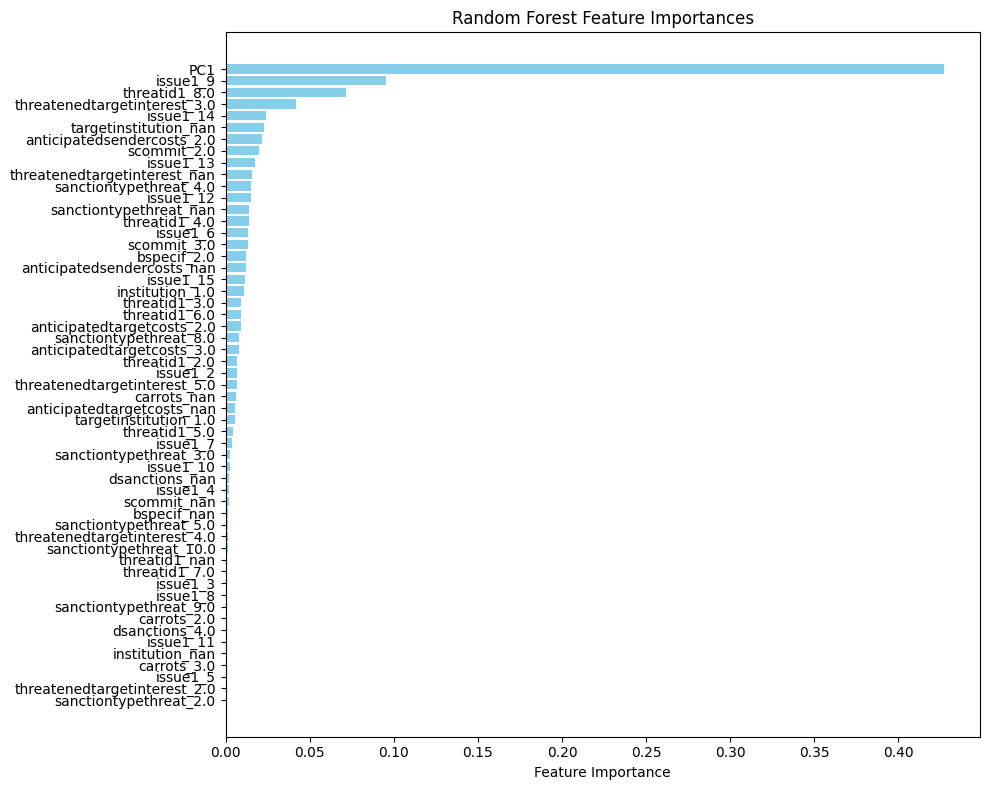

In [118]:
import matplotlib.pyplot as plt

# After calculating feature_importance_pairs as in the previous code snippet:
feature_importance_pairs = sorted(zip(final_feature_names, importances), key=lambda x: x[1], reverse=True)

# Unzip the feature_importance_pairs into two separate lists
sorted_features, sorted_importances = zip(*feature_importance_pairs)

plt.figure(figsize=(10, 8))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()  # Invert y-axis to have most important feature at the top
plt.tight_layout()
plt.show()


### Imposed

In [ ]:
# Start from the updated analysis_df as in the original code
analysis_df = final_merged.copy()

analysis_df = analysis_df.dropna(subset=['settlementnaturesender'])
analysis_df = analysis_df[analysis_df['settlementnaturesender'] >= 0]
analysis_df = analysis_df[analysis_df['imposition'] == 1]

# Identify polity -1 year variables
polity_minus_one_vars = [col for col in analysis_df.columns if col.endswith('_-1')]

# Listed TIES features (original + newly added)
ties_features = [
    'issue1', 'threatid1', 'sanctiontypethreat', 'bspecif', 'scommit',
    'threatenedtargetinterest', 'carrots', 'anticipatedtargetcosts',
    'anticipatedsendercosts', 'institution', 'targetinstitution', 'dsanctions',
    'sanctionidentity', 'sanctiontype', 'implementationofdiplomaticsancti',
    'carrotsduringsanction', 'targetcosts', 'sendercosts'
]
all_features = polity_minus_one_vars + ties_features

# Determine numeric vs categorical features
# Polity vars are numeric
numeric_features_candidates = polity_minus_one_vars

# Among ties_features:
# Numeric: anticipatedtargetcosts, anticipatedsendercosts, targetcosts, sendercosts

# The rest of ties_features are categorical
categorical_features_candidates = [
    'issue1', 'threatid1', 'sanctiontypethreat', 'bspecif', 'scommit',
    'threatenedtargetinterest', 'carrots', 'institution', 'targetinstitution', 'dsanctions', 'sanctionidentity', 
    'sanctiontype', 'implementationofdiplomaticsancti',
    'carrotsduringsanction'
]

# Convert to numeric where applicable
vars_to_process = final_features + ['settlementnaturesender']
for var in vars_to_process:
    if var in numeric_features_candidates:
        analysis_df[var] = pd.to_numeric(analysis_df[var], errors='coerce')
    elif var not in categorical_features_candidates:
        # Attempt numeric conversion if it's not identified as categorical or numeric
        analysis_df[var] = pd.to_numeric(analysis_df[var], errors='coerce')

analysis_df = analysis_df[final_features + ['settlementnaturesender']]

# Treat categorical features
for var in categorical_features_candidates:
    if var in analysis_df.columns:
        analysis_df[var] = analysis_df[var].astype(str).astype('category')
        # Add "Missing" category
        analysis_df[var] = analysis_df[var].cat.add_categories(["Missing"])
        analysis_df[var] = analysis_df[var].fillna("Missing")

# Impute median for numeric polity variables and numeric cost variables
for var in numeric_features_candidates:
    if var in analysis_df.columns:
        col_median = analysis_df[var].median()
        analysis_df[var] = analysis_df[var].fillna(col_median)

# Remove columns that are entirely NaN (after attempts)
for var in list(final_features):
    if var not in analysis_df.columns:
        continue
    if analysis_df[var].isna().all():
        print(f"Feature '{var}' is all NaN, removing it.")
        final_features.remove(var)
        analysis_df = analysis_df.drop(columns=[var], errors='ignore')

if not final_features:
    raise ValueError("No usable features remain after removing all-NaN columns.")

# Redefine numerical and categorical features after cleaning
numerical_features = [f for f in final_features if f in numeric_features_candidates]
categorical_features = [f for f in final_features if f in categorical_features_candidates]

# Generate impose probabilities from pipeline_prob_impose (assumes already defined and fitted)
# For impose_prob, we use the original features that pipeline_prob_impose expects. 
# In this simplified example, let's assume pipeline_prob_impose was trained on the original ties_features and polity vars.

# Include pred_impose_prob as numeric
numerical_features = numerical_features 
# Build preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            # ('pca', PCA(n_components=0.90))  # Retain 90% variance
        ]), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

# Define the full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

X = analysis_df[numerical_features + categorical_features]
y = analysis_df['predicted_probability']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Fit pipeline
pipeline.fit(X_train, y_train)

# Evaluate model
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print("---- Second Model (Settlement Nature Sender) ----")
print("Number of observations:", len(analysis_df))
print("Number of features after encoding:",
      len(numerical_features) +
      pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features).shape[0])
print("Intercept:", pipeline.named_steps['regressor'].intercept_)
print("R-squared on training set:", train_score)
print("R-squared on test set:", test_score)

# Retrieve feature names after preprocessing
cat_features_encoded = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
all_feature_names = list(numerical_features) + list(cat_features_encoded)

# Retrieve coefficients
model_coefficients = pipeline.named_steps['regressor'].coef_

# Display coefficients
print("Feature coefficients in second model:")
for feature, coef in zip(all_feature_names, model_coefficients):
    print(f"{feature}: {coef}")

In [208]:
# Start with the updated analysis_df as in the original code
analysis_df = final_merged.copy()

analysis_df = analysis_df.dropna(subset=['settlementnaturesender'])
analysis_df = analysis_df[analysis_df['settlementnaturesender'] >= 0]
analysis_df = analysis_df[analysis_df['imposition'] == 1]

# Identify polity -1 year variables
polity_minus_one_vars = [col for col in analysis_df.columns if col.endswith('_-1')]

ties_features = [
    'issue1', 'threatid1', 'sanctiontypethreat', 'bspecif', 'scommit',
    'threatenedtargetinterest', 'carrots', 'anticipatedtargetcosts',
    'anticipatedsendercosts', 'institution', 'targetinstitution', 'dsanctions',
    'sanctionidentity', 'sanctiontype', 'implementationofdiplomaticsancti',
    'carrotsduringsanction', 'targetcosts', 'sendercosts'
]

all_features = polity_minus_one_vars + ties_features

# Numeric and categorical features
numeric_features_candidates = polity_minus_one_vars + [
    'anticipatedtargetcosts', 'anticipatedsendercosts', 'targetcosts', 'sendercosts'
]

categorical_features_candidates = [
    'issue1', 'threatid1', 'sanctiontypethreat', 'bspecif', 'scommit',
    'threatenedtargetinterest', 'carrots', 'institution', 'targetinstitution', 
    'dsanctions', 'sanctionidentity', 'sanctiontype', 
    'implementationofdiplomaticsancti', 'carrotsduringsanction'
]

# Suppose final_features is defined as the set of features you want to use:
final_features = all_features  # or a subset of these

# Convert applicable columns
vars_to_process = final_features + ['settlementnaturesender']
for var in vars_to_process:
    if var in numeric_features_candidates:
        analysis_df[var] = pd.to_numeric(analysis_df[var], errors='coerce')
    elif var not in categorical_features_candidates:
        # Attempt numeric conversion for non-categorical vars
        analysis_df[var] = pd.to_numeric(analysis_df[var], errors='coerce')

analysis_df = analysis_df[final_features + ['settlementnaturesender', 'adjusted_delta']]

# Treat categorical features
for var in categorical_features_candidates:
    if var in analysis_df.columns:
        analysis_df[var] = analysis_df[var].astype(str).astype('category')
        analysis_df[var] = analysis_df[var].cat.add_categories(["Missing"])
        analysis_df[var] = analysis_df[var].fillna("Missing")

# Impute median for numeric vars
for var in numeric_features_candidates:
    if var in analysis_df.columns:
        col_median = analysis_df[var].median()
        analysis_df[var] = analysis_df[var].fillna(col_median)

# Drop columns that are all NaN
for var in list(final_features):
    if var not in analysis_df.columns:
        continue
    if analysis_df[var].isna().all():
        print(f"Feature '{var}' is all NaN, removing it.")
        final_features.remove(var)
        analysis_df = analysis_df.drop(columns=[var], errors='ignore')

if not final_features:
    raise ValueError("No usable features remain after removing all-NaN columns.")

# Redefine numerical and categorical features after cleaning
numerical_features = [f for f in final_features if f in numeric_features_candidates]
categorical_features = [f for f in final_features if f in categorical_features_candidates]

# Create a binary target variable: positive_impact = 1 if adjusted_delta > 0 else 0
analysis_df['positive_impact'] = (analysis_df['adjusted_delta'] > 0.0).astype(int)

X = analysis_df[numerical_features + categorical_features]
y = analysis_df['positive_impact']

# Build preprocessing pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
        ]), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

# Use a classification model now - LogisticRegression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=1000))
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Fit pipeline
pipeline.fit(X_train, y_train)

# Evaluate model with classification metrics
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print("---- Classification Model (Positive Impact) ----")
print("Number of observations:", len(analysis_df))
print("Training accuracy:", train_score)
print("Test accuracy:", test_score)

from sklearn.metrics import classification_report, confusion_matrix

y_pred = pipeline.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

---- Classification Model (Positive Impact) ----
Number of observations: 151
Training accuracy: 0.8571428571428571
Test accuracy: 0.6739130434782609
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.14      0.21        14
           1       0.71      0.91      0.79        32

    accuracy                           0.67        46
   macro avg       0.55      0.52      0.50        46
weighted avg       0.61      0.67      0.62        46

Confusion Matrix:
[[ 2 12]
 [ 3 29]]


c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 2, 5, 6, 10, 11, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 2, 5, 6, 10, 11, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [209]:
# Extract the numeric and encoded categorical feature names
numeric_feature_names = numerical_features

# Extract the one-hot encoded feature names for categorical variables
cat_encoder = pipeline.named_steps['preprocessor'].transformers_[1][1]  # The OHE from the pipeline
categorical_feature_names = cat_encoder.get_feature_names_out(categorical_features)

# Combine the two lists
all_feature_names = list(numeric_feature_names) + list(categorical_feature_names)

# Get coefficients from the logistic regression step
coefficients = pipeline.named_steps['classifier'].coef_[0]  # coef_ is array of shape (1, n_features) for binary LR

# Create a DataFrame for easier viewing and sorting
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'coefficient': coefficients
})

# Add absolute value of coefficients for sorting by importance
feature_importance_df['abs_coefficient'] = feature_importance_df['coefficient'].abs()

# Sort by absolute importance
feature_importance_df = feature_importance_df.sort_values('abs_coefficient', ascending=False)

print("Feature Importances:")
print(feature_importance_df)

Feature Importances:
                                               feature  coefficient  \
79                                sanctionidentity_1 2    -1.061486   
58                                         scommit_3.0     0.949740   
23                                            issue1_2     0.744843   
112                                   sanctiontype_nan    -0.720427   
22                                           issue1_15    -0.657594   
..                                                 ...          ...   
117                            carrotsduringsanction_3     0.013047   
9          Polity database: Regime Durability Index_-1     0.011454   
53                                sanctiontypethreat_9     0.002435   
67                          threatenedtargetinterest_4     0.002435   
1    Polity database: Competitiveness of Executive ...     0.000660   

     abs_coefficient  
79          1.061486  
58          0.949740  
23          0.744843  
112         0.720427  
22         

Coefficients:
                                               feature  coefficient  \
54                             sanctiontypethreat_4 10    -1.188577   
88                                sanctionidentity_1 2    -1.184123   
31                                       threatid1_2.0    -0.902580   
65                                         scommit_3.0     0.809961   
104                                 sanctionidentity_6    -0.759529   
..                                                 ...          ...   
84                               targetinstitution_nan    -0.025837   
62                                         bspecif_2.0     0.016639   
38                                       threatid1_nan    -0.012082   
141                          carrotsduringsanction_nan    -0.005748   
1    Polity database: Competitiveness of Executive ...     0.001467   

     abs_coefficient  
54          1.188577  
88          1.184123  
31          0.902580  
65          0.809961  
104         0.7595

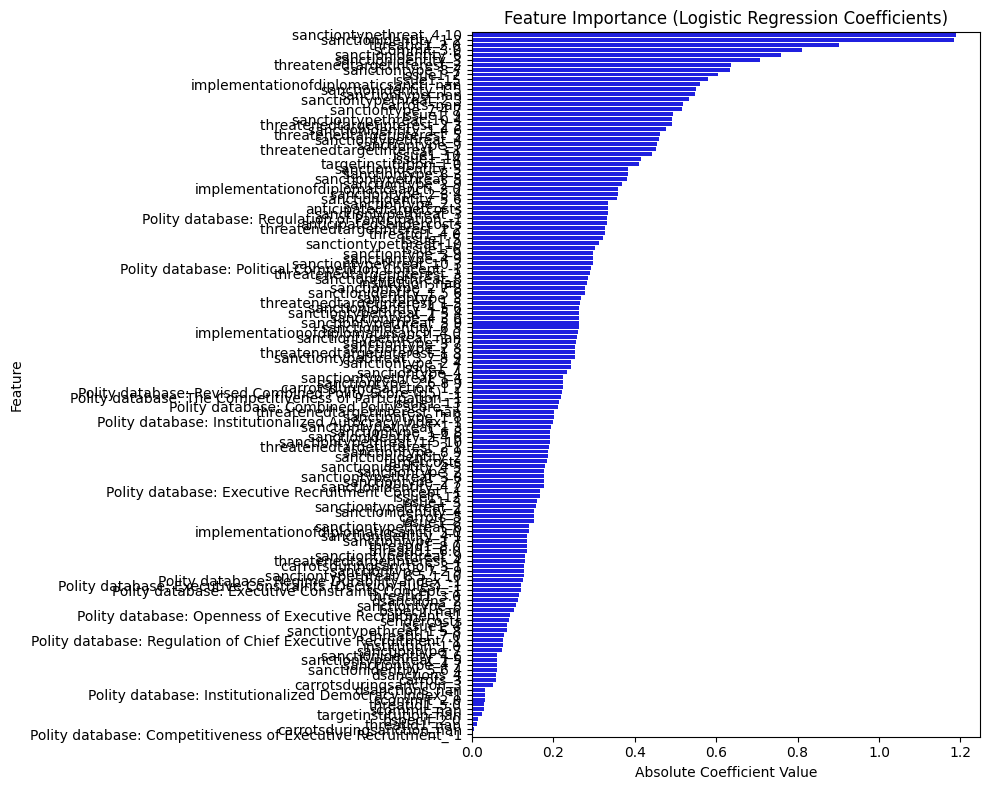

In [210]:
# Build the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
        ]), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

# Create logistic regression pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=1000))
])

X = analysis_df[numerical_features + categorical_features]
y = analysis_df['positive_impact']

# Fit the model on the entire dataset
pipeline.fit(X, y)

# Extract feature names
num_feature_names = numerical_features
cat_encoder = pipeline.named_steps['preprocessor'].transformers_[1][1]  # OHE step
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)

all_feature_names = list(num_feature_names) + list(cat_feature_names)

# Get coefficients from logistic regression
coefficients = pipeline.named_steps['classifier'].coef_[0]

# Create a DataFrame for coefficients
coef_df = pd.DataFrame({
    'feature': all_feature_names,
    'coefficient': coefficients
})

# Add absolute value for sorting by importance
coef_df['abs_coefficient'] = coef_df['coefficient'].abs()
coef_df = coef_df.sort_values('abs_coefficient', ascending=False)

print("Coefficients:")
print(coef_df)

# Plot coefficients
plt.figure(figsize=(10, 8))
sns.barplot(data=coef_df, x='abs_coefficient', y='feature', orient='h', color='blue')
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Top Features Driving Classification:
                                               feature  coefficient  \
54                             sanctiontypethreat_4 10    -1.188577   
88                                sanctionidentity_1 2    -1.184123   
31                                       threatid1_2.0    -0.902580   
65                                         scommit_3.0     0.809961   
104                                 sanctionidentity_6    -0.759529   
..                                                 ...          ...   
84                               targetinstitution_nan    -0.025837   
62                                         bspecif_2.0     0.016639   
38                                       threatid1_nan    -0.012082   
141                          carrotsduringsanction_nan    -0.005748   
1    Polity database: Competitiveness of Executive ...     0.001467   

     abs_coefficient  
54          1.188577  
88          1.184123  
31          0.902580  
65          0.8099

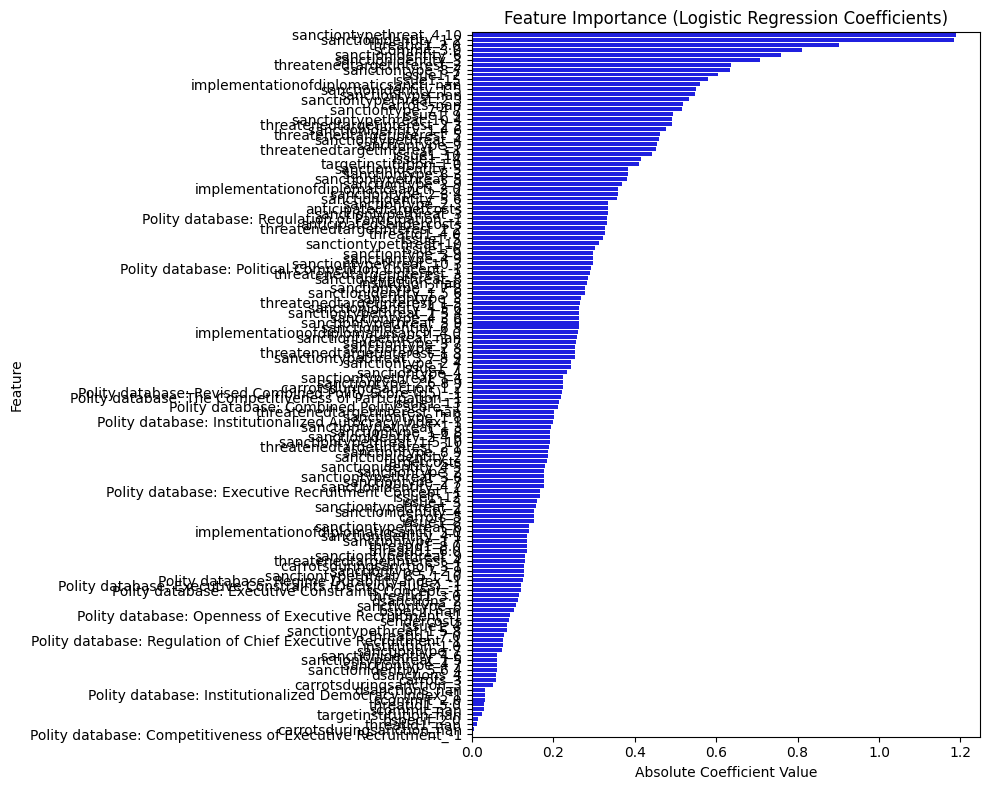

In [211]:
# Build preprocessing pipeline as before
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

# Create and fit logistic regression on entire dataset
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=1000))
])

pipeline.fit(X, y)

# Extract feature names
num_feature_names = numerical_features
cat_encoder = pipeline.named_steps['preprocessor'].transformers_[1][1] # The OHE step
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)

all_feature_names = list(num_feature_names) + list(cat_feature_names)

# Get coefficients from logistic regression
coefficients = pipeline.named_steps['classifier'].coef_[0]

# Create a DataFrame for coefficients
coef_df = pd.DataFrame({
    'feature': all_feature_names,
    'coefficient': coefficients
})

# Add absolute value for sorting by importance
coef_df['abs_coefficient'] = coef_df['coefficient'].abs()

# Sort by absolute coefficient value
coef_df = coef_df.sort_values('abs_coefficient', ascending=False)

print("Top Features Driving Classification:")
print(coef_df)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(data=coef_df, x='abs_coefficient', y='feature', orient='h', color='blue')
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [212]:

# 1. Initial pipeline with all features
preprocessor_full = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
        ]), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

pipeline_full = Pipeline([
    ('preprocessor', preprocessor_full),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=1000))
])

# Fit on entire dataset (or you could use a train/test split if you want)
pipeline_full.fit(X, y)

# Extract feature names
num_feature_names = numerical_features
cat_encoder = pipeline_full.named_steps['preprocessor'].transformers_[1][1] # OHE
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)

all_feature_names = list(num_feature_names) + list(cat_feature_names)
coefficients = pipeline_full.named_steps['classifier'].coef_[0]

coef_df = pd.DataFrame({
    'feature': all_feature_names,
    'coefficient': coefficients
})
coef_df['abs_coefficient'] = coef_df['coefficient'].abs()

# 2. Select top 10 features
top_10_features = (coef_df
                   .sort_values('abs_coefficient', ascending=False)
                   .head(10)
                   .feature
                   .tolist())

print("Top 10 Features Selected:")
print(top_10_features)

# Note: The top_10_features will be the transformed feature names. If you want to trace them back
# to original feature names for numeric vs categorical, you can—but typically you'll just use these
# directly as they appear after transformation. If you prefer to keep things simple and you know the
# original features that matter most, ensure those are the ones you input into the pipeline the second time.

# Important note:
# The features in `top_10_features` are from the transformed pipeline. Some will be from numeric features (which may directly match original names)
# and some will be from categorical features (which have OHE prefixes). 
# If you want to run a new model only on these top 10 features at the original DataFrame level, you need to identify the corresponding original features.

# However, if the top features are mostly numeric or single-category expansions, you can just pick their original features.
# Otherwise, if they are from OHE, you need to isolate which original categorical features/levels they correspond to.

# For simplicity, let's assume the top features include some numeric and some OHE categorical expansions.
# We'll now create a reduced dataset with only the necessary original features before encoding.

# Extract original feature names from OHE features
# OHE naming convention: <original_col>_<category>
# We'll parse them to find the needed original columns.

def get_original_features_from_ohe(ohe_features):
    original_features_set = set()
    for feat in ohe_features:
        # If this feature came from a categorical variable, it will have the form colName_value
        # We need just the original column name (colName)
        split_feat = feat.split('_', 1)
        if len(split_feat) == 2:  # Means it's from OHE
            original_features_set.add(split_feat[0])
        else:
            # Means it's a numeric feature or something not splitted
            original_features_set.add(feat)
    return list(original_features_set)

original_required_features = get_original_features_from_ohe(top_10_features)

print("Original required features:", original_required_features)

# Now filter X to include only these original features
X_reduced = X[original_required_features]

# We must also re-identify which are numeric and which are categorical in these top 10.
reduced_numerical_features = [f for f in original_required_features if f in numerical_features]
reduced_categorical_features = [f for f in original_required_features if f in categorical_features]

# Rebuild pipeline with only top features
preprocessor_reduced = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler())
        ]), reduced_numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), reduced_categorical_features)
    ],
    remainder='drop'
)

pipeline_reduced = Pipeline([
    ('preprocessor', preprocessor_reduced),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced'))
])

# Fit reduced pipeline
pipeline_reduced.fit(X_reduced, y)

# Evaluate the reduced model
print("Score with top 10 features only:", pipeline_reduced.score(X_reduced, y))

Top 10 Features Selected:
['sanctiontypethreat_4 10', 'sanctionidentity_1 2', 'threatid1_2.0', 'scommit_3.0', 'sanctionidentity_6', 'sanctionidentity_3', 'threatenedtargetinterest_2', 'sanctiontype_8 7', 'issue1_2', 'issue1_15']
Original required features: ['threatenedtargetinterest', 'sanctionidentity', 'sanctiontypethreat', 'threatid1', 'issue1', 'sanctiontype', 'scommit']
Score with top 10 features only: 0.8344370860927153


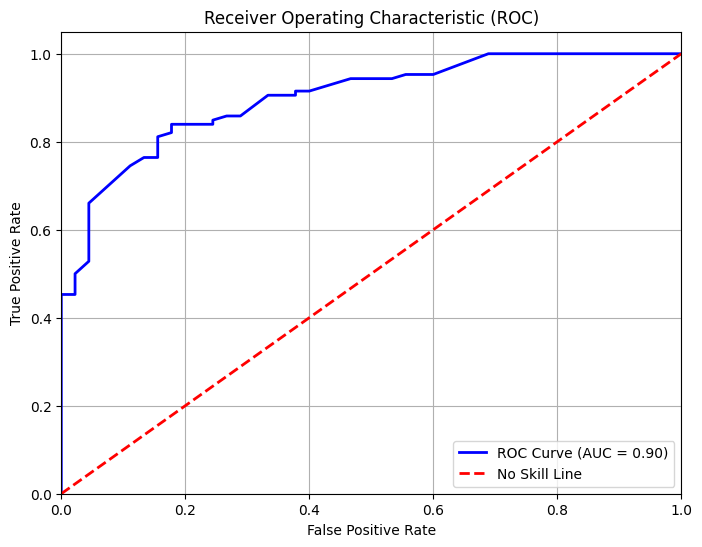

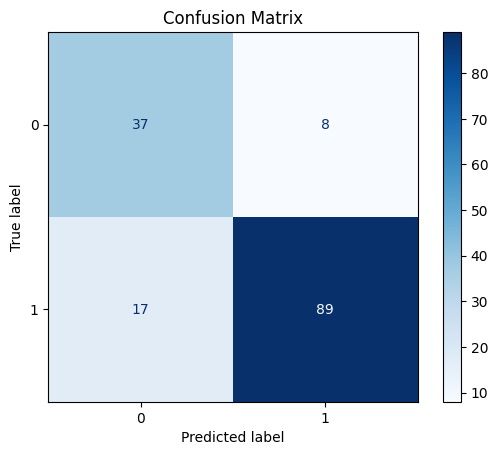

In [213]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict probabilities for ROC/AUC
y_scores = pipeline_reduced.predict_proba(X_reduced)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], color='red', lw=2, linestyle='--', label='No Skill Line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Predict labels for confusion matrix
y_pred = pipeline_reduced.predict(X_reduced)

# Compute confusion matrix
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Get the transformed numeric and categorical feature names
cat_encoder = pipeline_reduced.named_steps['preprocessor'].transformers_[1][1]  # The OHE step
cat_feature_names = cat_encoder.get_feature_names_out()
all_feature_names = list(numerical_features) + list(cat_feature_names)

# Get coefficients from the logistic regression model
coefficients = pipeline_reduced.named_steps['classifier'].coef_[0]

# Create a DataFrame for coefficients
coef_df = pd.DataFrame({
    'feature': all_feature_names,
    'coefficient': coefficients
})

# Add absolute value for sorting by importance
coef_df['abs_coefficient'] = coef_df['coefficient'].abs()

# Sort by absolute coefficient value
coef_df = coef_df.sort_values('abs_coefficient', ascending=False)

# Number of top features to visualize
n_top_features = 10  
top_features = coef_df.head(n_top_features)

print("Top Features by Absolute Coefficient Value:")
print(top_features)

# Plotting the coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='coefficient', y='feature', data=top_features,
            palette='coolwarm', orient='h')

plt.title('Top {} Most Important Features (Logistic Regression Coefficients)'.format(n_top_features))
plt.xlabel('Coefficient Value (Log Odds)')
plt.ylabel('Feature')
plt.axvline(x=0, color='black', linewidth=1)
plt.tight_layout()
plt.show()

ValueError: All arrays must be of the same length

In [222]:
# Transform the original data using the pipeline's preprocessor (assuming pipeline is fitted)
X_transformed = pipeline_reduced.named_steps['preprocessor'].transform(X)

# Extract feature names after transformation
cat_encoder = pipeline_reduced.named_steps['preprocessor'].transformers_[1][1]  # OHE step
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(cat_feature_names)

# Convert the transformed feature matrix to a DataFrame
# If X_transformed is a sparse matrix (common after OHE), convert it to dense if memory allows.
if hasattr(X_transformed, "toarray"):
    X_transformed = X_transformed.toarray()

df_transformed = pd.DataFrame(X_transformed, columns=all_feature_names)

# Compute correlation matrix (Pearson correlation by default)
corr_matrix = df_transformed.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

ValueError: input_features is not equal to feature_names_in_

In [218]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, log_loss

# We already have:
# y_true = y
# y_pred = pipeline_reduced.predict(X_reduced)
# y_scores = pipeline_reduced.predict_proba(X_reduced)[:, 1]

# Compute various metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
model_log_loss = log_loss(y, y_scores)

print("Model Performance Metrics:")
print("--------------------------")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Log Loss:", model_log_loss)
print()

# Classification report for a more detailed breakdown
print("Classification Report:")
print(classification_report(y, y_pred))


Model Performance Metrics:
--------------------------
Accuracy: 0.8344370860927153
Precision: 0.9175257731958762
Recall: 0.839622641509434
F1-Score: 0.8768472906403941
Log Loss: 0.5052517267520322

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        45
           1       0.92      0.84      0.88       106

    accuracy                           0.83       151
   macro avg       0.80      0.83      0.81       151
weighted avg       0.85      0.83      0.84       151



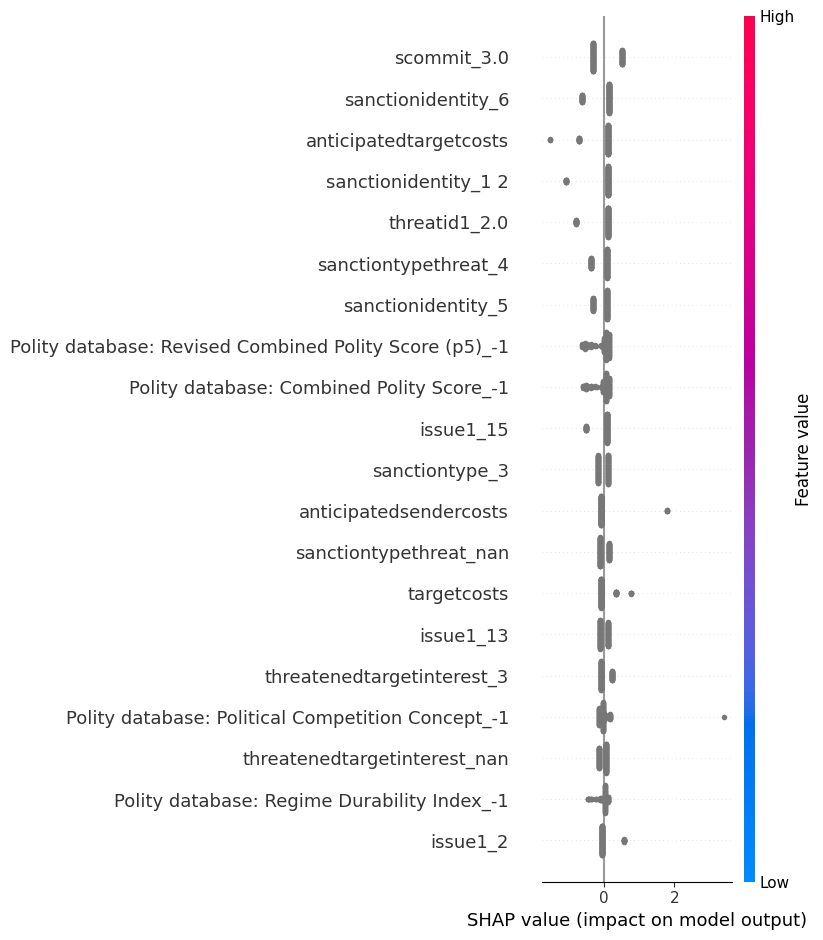

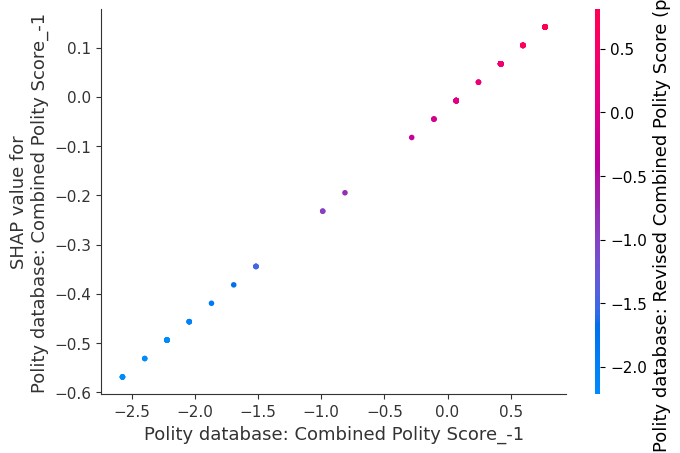

In [215]:
import shap
import pandas as pd
import numpy as np

# Assume:
# pipeline is your trained pipeline (with preprocessor and classifier)
# X is your original input dataframe
# y is your target
# numerical_features and categorical_features are defined as before.

# 1. Get the transformed feature matrix
X_transformed = pipeline.named_steps['preprocessor'].transform(X)

# 2. Extract the trained logistic regression model
log_reg = pipeline.named_steps['classifier']

# 3. Initialize a SHAP explainer
# For logistic regression, LinearExplainer is efficient.
explainer = shap.LinearExplainer(log_reg, X_transformed, feature_names=(numerical_features + list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features))))

# 4. Compute SHAP values for the same dataset (or a subset)
shap_values = explainer.shap_values(X_transformed)

# shap_values for a binary classification with LinearExplainer will return a single array 
# (or two arrays depending on version) representing the SHAP values for the positive class.

# 5. Summary Plot of SHAP values
shap.summary_plot(shap_values, X_transformed, feature_names=(numerical_features + list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features))))

# 6. Dependence Plot for a single feature
# Choose a feature name from the feature list
feature_of_interest = (numerical_features + list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)))[0]
X_dense = X_transformed.toarray()  # Convert sparse to dense
shap.dependence_plot(
    feature_of_interest, 
    shap_values, 
    X_dense, 
    feature_names=(numerical_features + list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)))
)
# 7. Force plot for an individual prediction
# Select an index for a single instance
index = 0
single_instance = X_transformed[index,:].toarray().flatten()
shap.force_plot(explainer.expected_value, shap_values[index,:], single_instance, 
                feature_names=(numerical_features + list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features))))


Top Features by Absolute Coefficient Value:
                             feature  coefficient  abs_coefficient
44      cat__sanctiontypethreat_4 10    -1.389498         1.389498
11         cat__sanctionidentity_1 2    -1.070311         1.070311
27           cat__sanctionidentity_6    -0.910643         0.910643
3    cat__threatenedtargetinterest_2    -0.909656         0.909656
17           cat__sanctionidentity_3    -0.838664         0.838664
52                cat__threatid1_2.0    -0.828505         0.828505
102                 cat__scommit_3.0     0.823921         0.823921
39       cat__sanctiontypethreat_2 3    -0.786208         0.786208
12       cat__sanctionidentity_1 4 6    -0.744462         0.744462
9    cat__threatenedtargetinterest_5    -0.718681         0.718681


C:\Users\maxla\AppData\Local\Temp\ipykernel_51168\1577894857.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coefficient', y='feature', data=top_features, palette='coolwarm', orient='h')


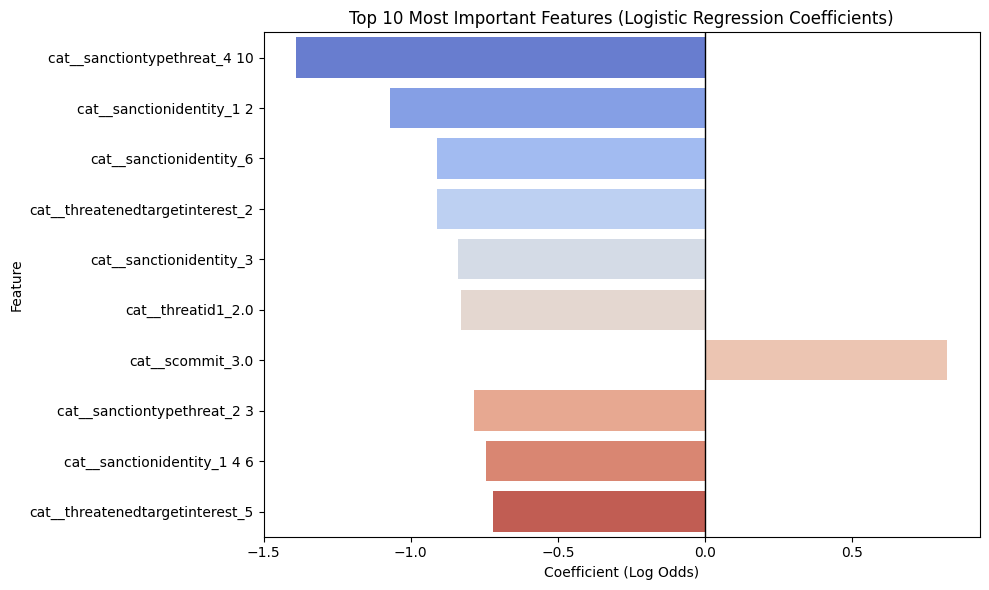

In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume pipeline_reduced is a fitted Pipeline with a preprocessing step (ColumnTransformer)
# and a classifier step (e.g., LogisticRegression), and that you have defined:
# numerical_features = [...]
# categorical_features = [...]

# Extract all feature names from the preprocessor
all_feature_names = pipeline_reduced.named_steps['preprocessor'].get_feature_names_out()

# Get coefficients from the logistic regression model
coefficients = pipeline_reduced.named_steps['classifier'].coef_[0]

# Confirm that lengths match
if len(all_feature_names) != len(coefficients):
    raise ValueError("Mismatch between number of features and number of coefficients.")

# Create a DataFrame for coefficients
coef_df = pd.DataFrame({
    'feature': all_feature_names,
    'coefficient': coefficients
})

# Add absolute value for sorting by importance
coef_df['abs_coefficient'] = coef_df['coefficient'].abs()

# Sort by absolute coefficient value
coef_df = coef_df.sort_values('abs_coefficient', ascending=False)

print("Top Features by Absolute Coefficient Value:")
print(coef_df.head(10))

# Plot the top 10 features
n_top_features = 10
top_features = coef_df.head(n_top_features)

plt.figure(figsize=(10, 6))
sns.barplot(x='coefficient', y='feature', data=top_features, palette='coolwarm', orient='h')
plt.title(f'Top {n_top_features} Most Important Features (Logistic Regression Coefficients)')
plt.xlabel('Coefficient (Log Odds)')
plt.ylabel('Feature')
plt.axvline(x=0, color='black', linewidth=1)
plt.tight_layout()
plt.show()


In [229]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have coef_df from previous steps with the sorted coefficients
# and df_transformed containing the transformed features.

# Select the top 10 most important features by absolute coefficient value
n_top_features = 10
top_features = coef_df.head(n_top_features)['feature'].tolist()

# Subset df_transformed to only the top 10 features
df_top = df_transformed[top_features]

# Compute correlation matrix for the top 10 features
corr_matrix_top = df_top.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_top, cmap='coolwarm', annot=True, fmt=".2f", square=True)
plt.title("Correlation Matrix of Top 10 Most Important Features")
plt.tight_layout()
plt.show()


KeyError: "None of [Index(['cat__sanctiontypethreat_4 10', 'cat__sanctionidentity_1 2',\n       'cat__sanctionidentity_6', 'cat__threatenedtargetinterest_2',\n       'cat__sanctionidentity_3', 'cat__threatid1_2.0', 'cat__scommit_3.0',\n       'cat__sanctiontypethreat_2 3', 'cat__sanctionidentity_1 4 6',\n       'cat__threatenedtargetinterest_5'],\n      dtype='object')] are in the [columns]"

Top 10 Features by Absolute Coefficient Value:
                             feature  coefficient  abs_coefficient
44      cat__sanctiontypethreat_4 10    -1.389498         1.389498
11         cat__sanctionidentity_1 2    -1.070311         1.070311
27           cat__sanctionidentity_6    -0.910643         0.910643
3    cat__threatenedtargetinterest_2    -0.909656         0.909656
17           cat__sanctionidentity_3    -0.838664         0.838664
52                cat__threatid1_2.0    -0.828505         0.828505
102                 cat__scommit_3.0     0.823921         0.823921
39       cat__sanctiontypethreat_2 3    -0.786208         0.786208
12       cat__sanctionidentity_1 4 6    -0.744462         0.744462
9    cat__threatenedtargetinterest_5    -0.718681         0.718681


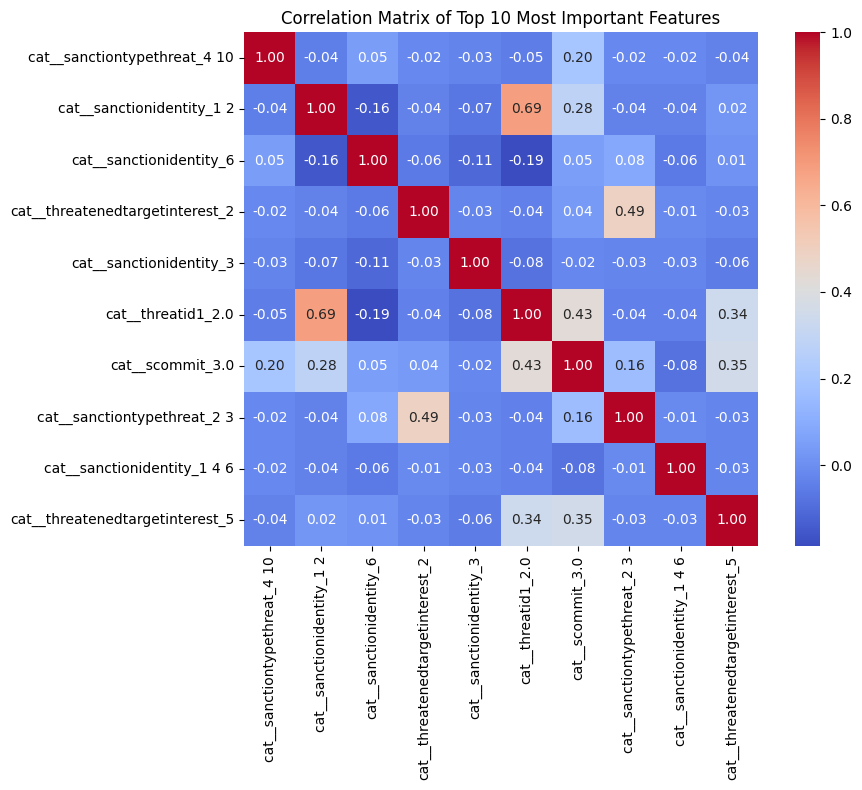

In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline

# Assuming these variables are defined:
# pipeline_reduced: a fitted pipeline with 'preprocessor' and 'classifier' steps
# X: your original feature DataFrame
# y: your target array or Series
# numerical_features: list of numeric features
# categorical_features: list of categorical features used in the pipeline

# 1. Transform the data using the pipeline’s preprocessor
X_transformed = pipeline_reduced.named_steps['preprocessor'].transform(X)

# 2. Extract feature names from the pipeline’s preprocessor
all_feature_names = pipeline_reduced.named_steps['preprocessor'].get_feature_names_out()

# 3. If X_transformed is sparse, convert to dense if memory allows
if hasattr(X_transformed, "toarray"):
    X_transformed = X_transformed.toarray()

# Create a DataFrame with transformed features
df_transformed = pd.DataFrame(X_transformed, columns=all_feature_names)

# 4. Extract coefficients from the classifier
coefficients = pipeline_reduced.named_steps['classifier'].coef_[0]

# Check length match
if len(all_feature_names) != len(coefficients):
    raise ValueError("Mismatch between number of features and number of coefficients.")

# Create a DataFrame for coefficients
coef_df = pd.DataFrame({
    'feature': all_feature_names,
    'coefficient': coefficients
})

# Add absolute coefficient column for sorting
coef_df['abs_coefficient'] = coef_df['coefficient'].abs()

# Sort by absolute coefficient and take top 10
n_top_features = 10
coef_df = coef_df.sort_values('abs_coefficient', ascending=False)
top_features = coef_df.head(n_top_features)['feature'].tolist()

print("Top 10 Features by Absolute Coefficient Value:")
print(coef_df.head(n_top_features))

# 5. Check if top_features match df_transformed's columns
# If there's a prefix mismatch (e.g., 'cat__'), remove it.
# This depends on how features were named. Check first:
missing_cols = [f for f in top_features if f not in df_transformed.columns]

if missing_cols:
    # If we find something like 'cat__' prefix, we can try removing it
    # Adjust this step based on actual prefix issues you discover
    top_features_adjusted = [f.replace('cat__', '') for f in top_features]
    # Check again after adjustment
    missing_cols_after = [f for f in top_features_adjusted if f not in df_transformed.columns]
    if missing_cols_after:
        raise ValueError(f"After removing 'cat__', these columns are still missing: {missing_cols_after}")
    top_features = top_features_adjusted

# 6. Subset df_transformed to the top 10 features
df_top = df_transformed[top_features]

# 7. Compute correlation matrix for top 10 features
corr_matrix_top = df_top.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_top, cmap='coolwarm', annot=True, fmt=".2f", square=True)
plt.title("Correlation Matrix of Top 10 Most Important Features")
plt.tight_layout()
plt.show()


In [233]:
final_merged

,caseid,startmonth,startday,startyear,endmonth,endday,endyear,ongoingasofmonth,ongoingasofday,ongoingasofyear,...,Polity database: The Competitiveness of Participation_16,Polity database: The Competitiveness of Participation_17,Polity database: The Competitiveness of Participation_18,Polity database: The Competitiveness of Participation_19,Polity database: The Competitiveness of Participation_20,predicted_probability_t,predicted_probability_tminus1,adjusted_delta,Merged_Group,Outcome_Group
384,1980010101,1.0,1.0,1980,NaN,NaN,1986.0,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,0.020263,0.048413,-0.027994,Other,Post-Sanction Failure
386,1980011101,1.0,11.0,1980,1.0,22.0,1981.0,NaN,NaN,NaN,...,5.0,5.0,5.0,5.0,5.0,0.048413,0.032782,0.015788,Merged,Post-Sanction Compliance
390,1980071401,7.0,14.0,1980,8.0,NaN,1986.0,NaN,NaN,NaN,...,3.0,4.0,4.0,3.0,4.0,0.063143,0.051824,0.011476,Other,Post-Sanction Failure
391,1980071402,7.0,14.0,1980,8.0,NaN,1986.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.043076,0.032782,0.010450,Merged,Post-Sanction Compliance
393,1980090201,9.0,2.0,1980,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.043076,0.032782,0.010450,Other,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1402,2005031501,3.0,15.0,2005,3.0,12.0,2009.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.023822,0.023822,0.000157,Other,Post-Sanction Failure
1404,2005042901,4.0,29.0,2005,11.0,25.0,2007.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.051824,0.048413,0.003568,Merged,Post-Sanction Compliance
1407,2005060701,6.0,7.0,2005,NaN,NaN,NaN,8.0,12.0,2011.0,...,NaN,NaN,NaN,NaN,NaN,0.011302,0.011302,0.000157,Other,Pre-Sanction Failure
1410,2005100601,10.0,6.0,2005,6.0,17.0,2010.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.032782,0.032782,0.000157,Other,Pre-Sanction Failure


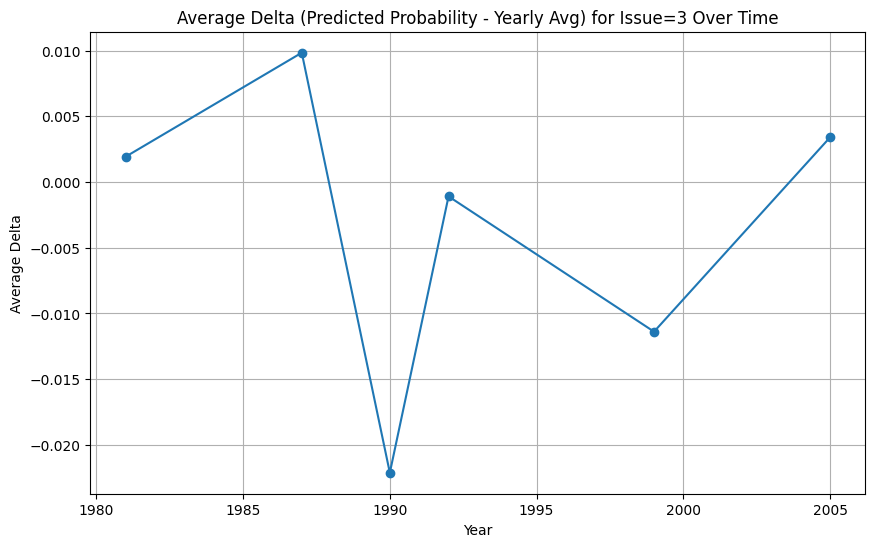

In [236]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume final_merged is your DataFrame
# and it has columns: 'Year', 'predicted_probability', and at least one column that indicates issue codes.

# 1. Compute the global yearly average predicted probability from final_merged
yearly_avg = final_merged.groupby('startyear')['predicted_probability_t'].mean().rename('yearly_avg')

# 2. Filter the dataset for issue = 3 (Destabilize Regime)
# If there's a single column 'issue' that directly states the issue code:
# final_merged_issue3 = final_merged[final_merged['issue'] == 3].copy()

# If the issues are listed in multiple columns (e.g. 'issue1', 'issue2', 'issue3') and you consider "issue=3" if any of them equals 3:
final_merged_issue3 = final_merged[
    (final_merged['issue1'] == 3) 
].copy()

# 3. Merge the yearly average back into the filtered dataset
final_merged_issue3 = final_merged_issue3.merge(yearly_avg, on='startyear', how='left')

# 4. Compute the delta: predicted_probability - that year's average predicted probability
final_merged_issue3['delta'] = final_merged_issue3['predicted_probability_t'] - final_merged_issue3['predicted_probability_tminus1']

# 5. Analyze or visualize the results
# For example, compute the average delta per year for these issue=3 cases:
avg_delta_per_year_issue3 = final_merged_issue3.groupby('startyear')['delta'].mean()

# Plot the average delta over time
plt.figure(figsize=(10,6))
avg_delta_per_year_issue3.plot(marker='o')
plt.title('Average Delta (Predicted Probability - Yearly Avg) for Issue=3 Over Time')
plt.xlabel('Year')
plt.ylabel('Average Delta')
plt.grid(True)
plt.show()


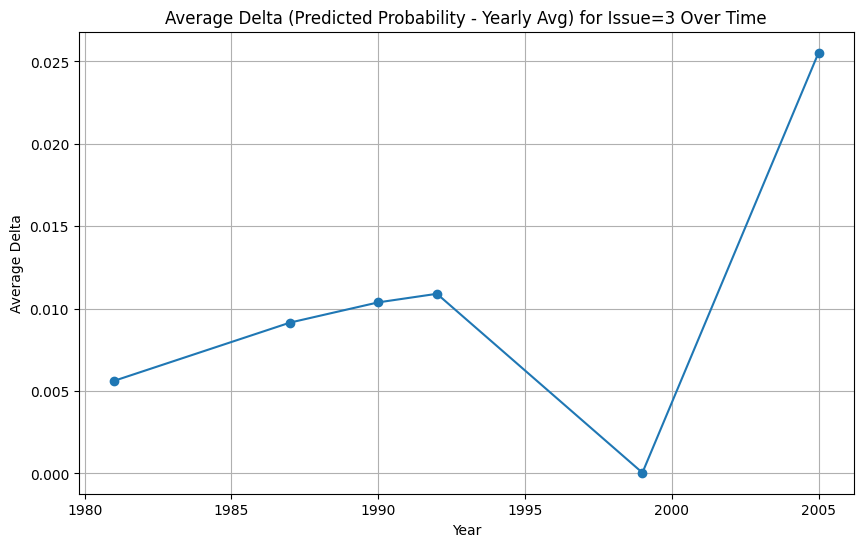

In [240]:
# Compute the global yearly average predicted probability
# using 'predicted_probability_t' grouped by 'startyear'
yearly_avg = final_merged.groupby('startyear')['predicted_probability_t'].mean().rename('yearly_avg')

# Filter the dataset for issue = 3 (Destabilize Regime)
# If 'issue1' indicates the issue code, and we consider cases where issue1 = 3
final_merged_issue3 = final_merged[final_merged['issue1'] == 3].copy()

# Merge the yearly average back into the filtered dataset
final_merged_issue3 = final_merged_issue3.merge(yearly_avg, on='startyear', how='left')

# Compute the delta: (predicted_probability_t - yearly_avg)
final_merged_issue3['delta'] = final_merged_issue3['predicted_probability_t'] - final_merged_issue3['yearly_avg']

# Compute the average delta per year for these issue=3 cases
avg_delta_per_year_issue3 = final_merged_issue3.groupby('startyear')['delta'].mean()

# Plot the average delta over time
plt.figure(figsize=(10,6))
avg_delta_per_year_issue3.plot(marker='o')
plt.title('Average Delta (Predicted Probability - Yearly Avg) for Issue=3 Over Time')
plt.xlabel('Year')
plt.ylabel('Average Delta')
plt.grid(True)
plt.show()

In [237]:
# Compute mean
mean_delta = final_merged_issue3['delta'].mean()

# Compute standard deviation
std_delta = final_merged_issue3['delta'].std(ddof=1)  # ddof=1 for sample std

# Compute sample size
n = final_merged_issue3['delta'].count()

# Compute standard error
se = std_delta / np.sqrt(n)

# z-score for 95% confidence interval
z = 1.96  # approximately for large samples

# Margin of error
me = z * se

# 95% confidence interval
ci_lower = mean_delta - me
ci_upper = mean_delta + me

print("Average Impact (Mean Delta):", mean_delta)
print("95% CI: ({:.5f}, {:.5f})".format(ci_lower, ci_upper))

Average Impact (Mean Delta): -0.005932059323732028
95% CI: (-0.01779, 0.00593)


In [243]:
# 1. Compute mean and std of predicted_probability_t per country
country_stats = final_merged.groupby('Country_Code')['predicted_probability_t'].agg(['mean', 'std']).reset_index()
country_stats.rename(columns={'mean': 'mean_pred', 'std': 'std_pred'}, inplace=True)

# 2. Merge these statistics back into final_merged
final_merged = final_merged.merge(country_stats, on='Country_Code', how='left')

# 3. Compute z-score: (predicted_probability_t - mean_pred) / std_pred
final_merged['z_score'] = (final_merged['predicted_probability_t'] - final_merged['mean_pred']) / final_merged['std_pred']


# 5. Compute the average z-score of imposed cases
avg_z_score_imposed = final_merged['z_score'].mean()

print("Average Z-Score at times when sanctions are imposed:", avg_z_score_imposed)

Average Z-Score at times when sanctions are imposed: 2.70168340593194e-17
